In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import itertools
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from joblib import parallel_backend
from sklearn.model_selection import GridSearchCV
import sys
import os
from tensorflow import keras

# Initial Exploration and Preprocessing

In [2]:
# try to parse date variables and also include the cells with space only as NA
harvard = pd.read_csv("data/Original Data/original_data.csv", sep=";", parse_dates=['toflhadt', 'toflhadt02', 'bclinra01b', 'bclinra02b', 'bclinra05', 'bclinra13', 'bclinra15', 'bclinra17', 'fclinra67', 'fclinra07', 'fclinra10', 'fclinra13', 'fclinra16', ], na_values=[' '], low_memory=False)

# print how many unique values there are in the login column (patients)
unique_patients = harvard['login'].nunique()
print("There are {} unique patients in the dataset.".format(unique_patients))

There are 188 unique patients in the dataset.


### Variable renaming

In [3]:
# placeholder for naming variables

rename_dict = {
    'bclinra202c_2': 'Measured FEV1',
    'PROMISPhyFunctionBankv1_SE': 'Physical Funct. SE',
    'PROMISDepressionBankv1_SE': 'Depression SE',
    'PROMISAnxietyBankv1_SE': 'Anxiety SE',
    'PROMISFatigueBankv1_SE': 'Fatigue SE',
    'bclinra205': 'FEV1/FVC',
    'bclinra204c_2': '% predicted PEF',
    'PROMISSocialSatSRBankv1_SE': 'Soc. Satisfaction',
    'PROMISPhyFunctionBankv1_Theta': 'Phy. Funct. Theta',
    'PROMISDepressionBankv1_Theta': 'Depression Theta',
    'PROMISAnxietyBankv1_Theta': 'Anxiety Theta',
    'PROMISFatigueBankv1_Theta': 'Fatigue Theta',
    'PROMISSocialSatSRBankv1_Theta': 'Soc. Satisfaction Theta',
    'sgrq_sx_r': 'SGRQ Symptoms',
    'sgrq_imp_r': 'SGRQ Impacts',
    'PROMISAngerBankv1_SE': 'Anger SE',
    'PROMISAngerBankv1_Theta': 'Anger Theta',
    'bclinra202': 'Pred. FEV1',
    'exact6': 'Chest tightness',
    'PROMISPainImpactBankv1_Theta': 'Pain Impact Theta',
    'PROMISPainImpactBankv1_SE': 'Pain Impact SE',
    'bclinra02': 'Weight (kg)',
}



## Variable Types

<BarContainer object of 4 artists>

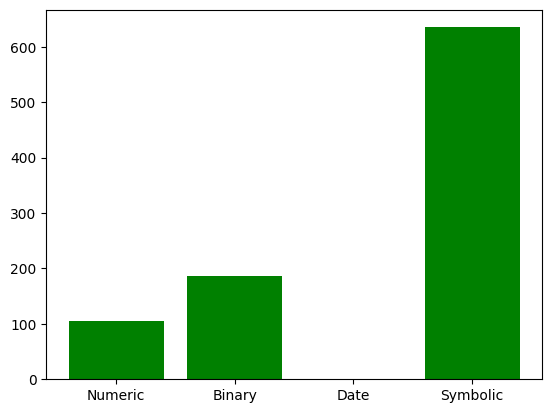

In [4]:
datetime_vars = ['toflhadt', 'toflhadt02', 'bclinra01b', 'bclinra02b', 'bclinra05', 'bclinra13', 'bclinra15', 'bclinra17', 'fclinra67', 'fclinra07', 'fclinra10', 'fclinra13', 'fclinra16', 'psqi01', 'psqi03', ]

# find out how many variables are for different categories date, binary, categorical, and numerical
from pandas import DataFrame
def get_variable_types(df: DataFrame) -> dict:
    variable_types: dict = {
        'Numeric': [],
        'Binary': [],
        'Date': [],
        'Symbolic': []
    }
    for c in df.columns:
        uniques = df[c].dropna(inplace=False).unique()
        if len(uniques) == 2:
            variable_types['Binary'].append(c)
            df[c].astype('bool')
        elif df[c].dtype == 'datetime64':
            variable_types['Date'].append(c)
        elif df[c].dtype == 'int':
            variable_types['Numeric'].append(c)
        elif df[c].dtype == 'float':
            variable_types['Numeric'].append(c)
        else:
            df[c].astype('category')
            variable_types['Symbolic'].append(c)

    return variable_types

variable_types = get_variable_types(harvard)

# make sure print statements are not truncated
pd.set_option('display.max_columns', None)
# remove sr_ft from binary variables and add it to numeric variables
variable_types['Numeric'].append('sr_ft')
variable_types['Binary'].remove('sr_ft')

# remove all variables containing 'EDANG' from binary variables and add them to categorical variables
for var in variable_types['Binary']:
    if 'Bank' in var:
        variable_types['Symbolic'].append(var)
        variable_types['Binary'].remove(var)

# remove these variables from binary and add them to categorical
for var in ['EDANG18_Bank', 'EDANG56_Bank', 'EDANX33_Bank', 'EDDEP05_Bank', 'EDDEP14_Bank', 'EDDEP21_Bank', 'EDDEP48_Bank', 'PAINBE39_Bank', 'PAINBE41_Bank', 'PFA35_Bank', 'PFA40_Bank', 'PFA44_Bank', 'PFA51_Bank', 'PFB21_Bank', 'PFB33_Bank', 'PFB41_Bank', 'PFC45_Bank', 'PFC49_Bank', 'PFC52_Bank', 'psqi5', 'nvalid_ph', 'fclinra17']:
    variable_types['Symbolic'].append(var)
    variable_types['Binary'].remove(var)

# should be binary:
to_be_binary = ["mc_med9", "Elig01", "Elig04", "Elig05", "Elig06", "Elig07", "Elig08", "Elig13", "bclinra06_256", "fclinra01_256"] 

for var in to_be_binary:
    variable_types['Binary'].append(var)
    variable_types['Numeric'].remove(var)

# should be categorical:
to_be_categorical = ["dem05", "dem05_16", "socio06", "Socio07", "dem08_128", "dem08", "bclinpt20", "bclinpt21", "bclinpt22", "bclinpt23", "bclinpt24", "bclinpt25", "bclinpt26", "bclinpt27", "bclinpt43", "bclinra06", "bclinra08", "bclinra11", "bclinra16", "fclinra02", "fclinra04", "Elig02", "Elig03", "bclinra03", "bclinra07", "fclinicpt03", "fclinpt04", "fclinpt05", "fclinra01", "GeneralHealth", "Global02", "Global03", "Global04", "Global05", "Global06", "Global07", "Global08", "Global09", "Global10", "An1_Bank", "An2_Bank", "An3_Bank", "An4_Bank", "An5_Bank", "An7_Bank", "An8_Bank", "An12_Bank", "An14_Bank", "An15_Bank", "An16_Bank", "EDANG01_Bank", "EDANG03_Bank", "EDANG03_SF", "EDANG04_Bank", "EDANG05_Bank", "EDANG06_Bank", "EDANG06_SF", "EDANG09_Bank", "EDANG09_SF", "EDANG10_Bank", "EDANG11_Bank", "EDANG15_Bank", "EDANG15_SF", "EDANG16_Bank", "EDANG17_Bank", "EDANG21_Bank", "EDANG22_Bank", "EDANG25_Bank", "EDANG25_SF", "EDANG26_Bank", "EDANG28_Bank", "EDANG28_SF", "EDANG30_Bank", "EDANG31_Bank", "EDANG35_Bank", "EDANG35_SF", "EDANG37_Bank", "EDANG45_Bank", "EDANG47_Bank", "EDANG48_Bank", "EDANG54_Bank", "EDANG55_Bank", "EDANX01_Bank", "EDANX01_SF", "EDANX02_Bank", "EDANX03_Bank", "EDANX05_Bank", "EDANX05_SF", "EDANX07_Bank", "EDANX08_Bank", "EDANX12_Bank", "EDANX13_Bank", "EDANX16_Bank", "EDANX18_Bank", "EDANX20_Bank", "EDANX21_Bank", "EDANX26_Bank", "EDANX27_Bank", "EDANX30_Bank", "EDANX30_SF", "EDANX40_Bank", "EDANX40_SF", "EDANX41_Bank", "EDANX44_Bank", "EDANX46_Bank", "EDANX46_SF", "EDANX47_Bank", "EDANX48_Bank", "EDANX49_Bank", "EDANX51_Bank", "EDANX53_Bank", "EDANX54_Bank", "EDANX54_SF", "EDANX55_Bank", "EDDEP04_Bank", "EDDEP04_SF","EDDEP05_SF","EDDEP06_Bank","EDDEP06_SF","EDDEP09_Bank","EDDEP17_Bank","EDDEP17_SF","EDDEP22_Bank","EDDEP22_SF","EDDEP23_Bank","EDDEP26_Bank","EDDEP27_Bank","EDDEP28_Bank","EDDEP29_Bank","EDDEP30_Bank","EDDEP31_Bank","EDDEP35_Bank","EDDEP36_Bank","EDDEP36_SF","EDDEP41_Bank","EDDEP41_SF","EDDEP42_Bank","EDDEP44_Bank","EDDEP45_Bank","EDDEP46_Bank","EDDEP50_Bank","EDDEP54_Bank","FATEXP2_Bank","FATEXP5_SF","FATEXP7_Bank","FATEXP5_Bank","FATEXP12_Bank","FATEXP13_Bank","FATEXP16_Bank","FATEXP18_Bank","FATEXP18_SF","FATEXP19_Bank","FATEXP20_Bank","FATEXP20_SF","FATEXP21_Bank","FATEXP22_Bank","FATEXP24_Bank","FATEXP26_Bank","FATEXP28_Bank","FATEXP29_Bank","FATEXP31_Bank","FATEXP34_Bank","FATEXP35_Bank","FATEXP36_Bank","FATEXP38_Bank","FATEXP40_Bank","FATEXP41_Bank","FATEXP42_Bank","FATEXP43_Bank","FATEXP44_Bank","FATEXP45_Bank","FATEXP46_Bank","FATEXP48_Bank","FATEXP49_Bank","FATEXP50_Bank","FATEXP51_Bank","FATEXP52_Bank","FATEXP54_Bank","FATEXP56_Bank","FATEXP6_Bank","FATIMP1_Bank","FATIMP2_Bank","FATIMP3_Bank","FATIMP4_Bank","FATIMP5_Bank","FATIMP6_Bank","FATIMP8_Bank","FATIMP9_Bank","FATIMP10_Bank","FATIMP11_Bank","FATIMP13_Bank","FATIMP14_Bank","FATIMP15_Bank","FATIMP16_Bank","FATIMP17_Bank","FATIMP18_Bank","FATIMP19_Bank","FATIMP20_Bank","FATIMP21_Bank","FATIMP21_SF","FATIMP22_Bank","FATIMP24_Bank","FATIMP25_Bank","FATIMP26_Bank","FATIMP27_Bank","FATIMP28_Bank","FATIMP29_Bank","FATIMP30_Bank","FATIMP30_SF","FATIMP33_Bank","FATIMP33_SF","FATIMP34_Bank","FATIMP35_Bank","FATIMP36_Bank","FATIMP37_Bank","FATIMP38_Bank","FATIMP40_Bank","FATIMP40_SF","FATIMP42_Bank","FATIMP43_Bank","FATIMP44_Bank","FATIMP45_Bank","FATIMP47_Bank","FATIMP48_Bank","FATIMP49_Bank","FATIMP50_Bank","FATIMP51_Bank", "FATIMP52_Bank", "FATIMP53_Bank", "FATIMP55_Bank", "FATIMP56_Bank", "HI12_Bank", "HI7_Bank", "PAINBE2_Bank", "PAINBE2_SF", "PAINBE3_Bank", "PAINBE3_SF", "PAINBE6_Bank", "PAINBE8_Bank", "PAINBE9_Bank", "PAINBE11_Bank", "PAINBE13_Bank", "PAINBE16_Bank", "PAINBE17_Bank", "PAINBE18_Bank", "PAINBE21_Bank", "PAINBE22_Bank", "PAINBE23_Bank", "PAINBE24_Bank", "PAINBE24_SF", "PAINBE25_Bank", "PAINBE25_SF", "PAINBE26_Bank", "PAINBE27_Bank", "PAINBE28_Bank", "PAINBE29_Bank", "PAINBE31_Bank", "PAINBE32_Bank", "PAINBE33_Bank", "PAINBE35_Bank", "PAINBE37_Bank", "PAINBE37_SF", "PAINBE38_Bank", "PAINBE42_Bank", "PAINBE43_Bank", "PAINBE44_Bank", "PAINBE45_Bank", "PAINBE45_SF", "PAINBE46_Bank", "PAINBE47_Bank", "PAINBE48_Bank", "PAINBE49_Bank", "PAINBE50_Bank", "PAINBE51_Bank", "PAININ1_Bank", "PAININ3_Bank", "PAININ3_SF", "PAININ5_Bank", "PAININ6_Bank", "PAININ8_SF", "PAININ9_Bank", "PAININ10_Bank", "PAININ10_SF", "PAININ11_Bank", "PAININ12_Bank", "PAININ13_Bank", "PAININ14_Bank", "PAININ14_SF", "PAININ16_Bank", "PAININ17_Bank", "PAININ18_Bank", "PAININ19_Bank", "PAININ20_Bank", "PAININ22_Bank", "PAININ24_Bank", "PAININ26_Bank", "PAININ26_SF", "PAININ29_Bank", "PAININ31_Bank", "PAININ32_Bank", "PAININ34_Bank", "PAININ35_Bank", "PAININ36_Bank", "PAININ37_Bank", "PAININ38_Bank", "PAININ39_Bank", "PAININ40_Bank", "PAININ42_Bank", "PAININ46_Bank", "PAININ47_Bank", "PAININ48_Bank", "PAININ49_Bank", "PAININ50_Bank", "PAININ51_Bank", "PAININ52_Bank", "PAININ53_Bank", "PAININ54_Bank", "PAININ55_Bank", "PAININ56_Bank", "PFA1_Bank", "PFA1_SF", "PFA3_Bank", "PFA3_SF", "PFA4_Bank", "PFA5_SF", "PFA6_Bank", "PFA7_Bank", "PFA8_Bank", "PFA9_Bank", "PFA10_Bank", "PFA11_Bank", "PFA11_SF", "PFA12_Bank", "PFA13_Bank", "PFA14_Bank", "PFA15_Bank", "PFA16_Bank", "PFA16_SF", "PFA17_Bank", "PFA18_Bank", "PFA19_Bank", "PFA20_Bank", "PFA21_Bank", "PFA22_Bank", "PFA23_Bank", "PFA25_Bank", "PFA28_Bank", "PFA29_Bank", "PFA30_Bank", "PFA31_Bank", "PFA32_Bank", "PFA33_Bank", "PFA34_Bank", "PFA37_Bank", "PFA38_Bank", "PFA39_Bank", "PFA41_Bank", "PFA42_Bank", "PFA45_Bank", "PFA47_Bank", "PFA48_Bank", "PFA49_Bank", "PFA5_Bank", "PFA52_Bank", "PFA53_Bank", "PFA55_Bank", "PFA55_SF", "PFA56_Bank", "PFB1_Bank", "PFB3_Bank", "PFB5_Bank", "PFB7_Bank", "PFB8_Bank", "PFB9_Bank", "PFB10_Bank", "PFB11_Bank", "PFB12_Bank", "PFB13_Bank", "PFB14_Bank", "PFB15_Bank", "PFB16_Bank", "PFB17_Bank", "PFB18_Bank", "PFB19_Bank", "PFB20_Bank", "PFB23_Bank", "PFB24_Bank", "PFB25_Bank", "PFB26_Bank", "PFB26_SF", "PFB27_Bank", "PFB28_Bank", "PFB29_Bank", "PFB30_Bank", "PFB31_Bank", "PFB32_Bank", "PFB34_Bank", "PFB36_Bank", "PFB39_Bank", "PFB40_Bank", "PFB42_Bank", "PFB43_Bank", "PFB44_Bank", "PFB48_Bank", "PFB49_Bank", "PFB50_Bank", "PFB54_Bank", "PFB56_Bank", "PFC6_Bank", "PFC7_Bank", "PFC10_Bank", "PFC12_Bank", "PFC13_Bank", "PFC20_Bank", "PFC29_Bank", "PFC31_Bank", "PFC32_Bank", "PFC33_Bank", "PFC34_Bank", "PFC35_Bank", "PFC36_Bank", "PFC36_SF", "PFC37_Bank", "PFC37_SF", "PFC38_Bank", "PFC39_Bank", "PFC40_Bank", "PFC41_Bank", "PFC43_Bank", "PFC45_SF", "PFC46_Bank", "PFC54_Bank", "PFC56_Bank", "SRPSAT05_Bank", "SRPSAT05_SF", "SRPSAT06_Bank", "SRPSAT06_SF", "SRPSAT07_Bank", "SRPSAT07_SF", "SRPSAT08_Bank", "SRPSAT09_Bank", "SRPSAT10_Bank", "SRPSAT10_SF", "SRPSAT19_Bank", "SRPSAT20_Bank", "SRPSAT20_SF", "SRPSAT21_Bank", "SRPSAT22_Bank", "SRPSAT23_Bank", "SRPSAT24_Bank", "SRPSAT24_SF", "SRPSAT25_Bank", "SRPSAT25_SF", "SRPSAT33_Bank", "SRPSAT34_Bank", "SRPSAT35_Bank", "SRPSAT36_Bank", "SRPSAT37_Bank", "SRPSAT38_Bank", "SRPSAT39_Bank", "SRPSAT39_SF", "SRPSAT47_Bank", "SRPSAT48_Bank", "SRPSAT48_SF", "SRPSAT49_Bank", "SRPSAT50_Bank", "SRPSAT50_SF", "SRPSAT51_Bank", "SRPSAT51_SF", "SRPSAT52_Bank", "exact1", "exact2", "exact3", "exact4", "exact5", "exact6", "exact7", "exact8", "exact9", "exact10", "exact11", "exact12", "exact13", "exact14", "facit_06", "facit_10", "facit_15", "facit_19", "facit_20", "facit_21", "facit_23", "facit_26", "facit_30", "facit_45", "facit2_06", "facit2_10", "facit2_15", "facit2_19", "facit2_20", "facit2_21", "facit2_23", "facit2_26", "facit2_30", "facit2_45", "psqi05", "psqi06", "psqi07", "psqi08", "psqi09", "psqi10", "psqi11", "psqi12", "psqi13", "psqi14", "psqi15", "psqi16", "psqi17", "psqi18", "sgrq01", "sgrq02", "sgrq03", "sgrq04", "sgrq05", "sgrq06", "sgrq07", "sgrq08", "sgrq10", "sgrq12", "sgrq53", 'mmrc', 'sleep7', 'sleep6', "psqidurat", "psqidistb", "psqilaten", "psqidaydys", "psqihse", "nvalid_ang","nvalid_anx",  "nvalid_dep", "nvalid_fatig", "nvalid_painbe", "nvalid_painin", "nvalid_phy", "nvalid_dsa", "nvalid_sr", "nvalid_mh"]

for var in to_be_categorical:
    variable_types['Symbolic'].append(var)
    variable_types['Numeric'].remove(var)

# create a bar plot with the number of variables in each type
plt.bar(variable_types.keys(), [len(v) for v in variable_types.values()], color='g')

## Variables per Questionnaire

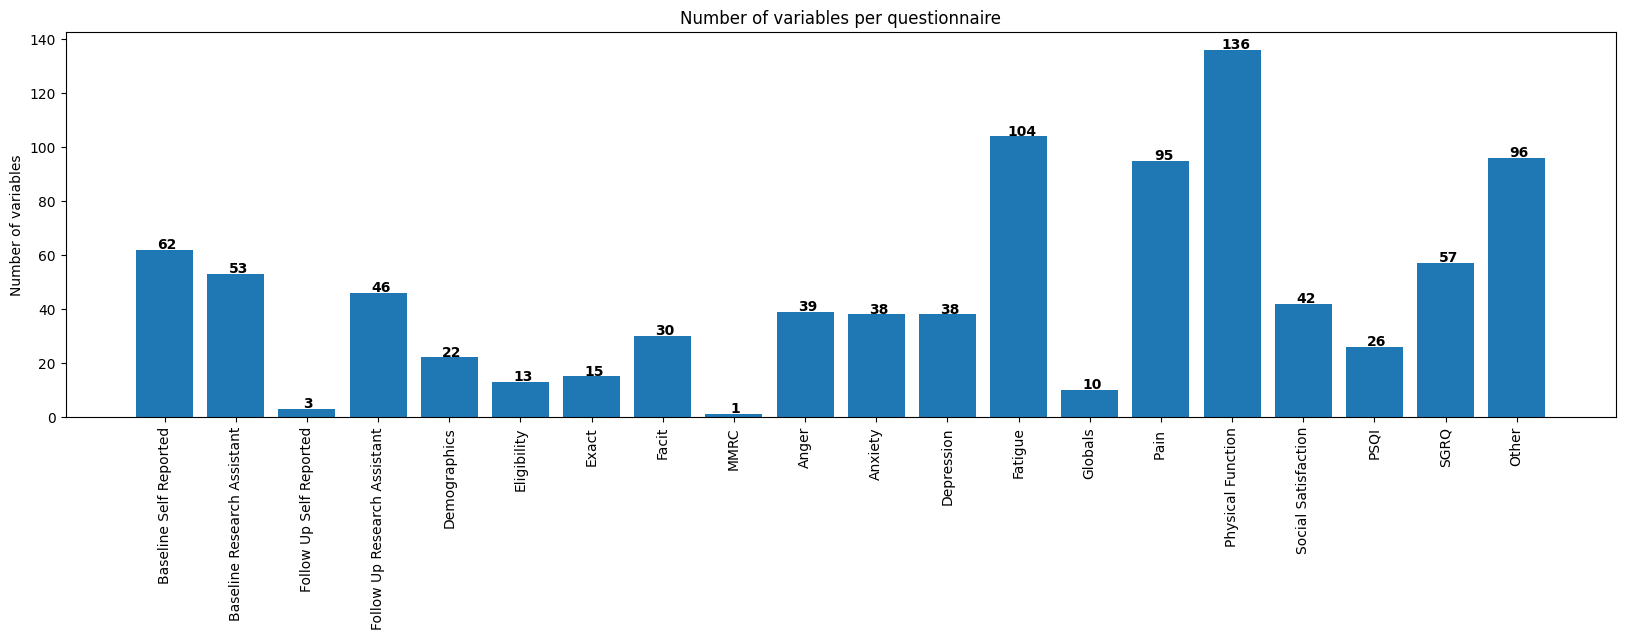

In [5]:
baseline_self_reported = harvard.filter(regex='bclinpt')
baseline_research_assistant = harvard.filter(regex='bclinra')
follow_up_self_reported = harvard.filter(regex='fclinpt')
follow_up_self_reported = pd.concat([follow_up_self_reported, harvard.filter(regex='fclinicpt')], axis=1)
follow_up_research_assistant = harvard.filter(regex='fclinra')
demographics = harvard.filter(regex='dem0')
demographics = pd.concat([demographics, harvard.filter(regex='dem101')], axis=1)
demographics = pd.concat([demographics, harvard.filter(regex='socio')], axis=1)
demographics = pd.concat([demographics, harvard.filter(regex='Socio')], axis=1)
eligibility = harvard.filter(regex='elig')
eligibility = pd.concat([eligibility, harvard.filter(regex='Elig')], axis=1)
exact = harvard.filter(regex='exact')
exact = pd.concat([exact, harvard.filter(regex='Exact')], axis=1)
facit = harvard.filter(regex='facit')
# gac = harvard.filter(regex='GAC')
mmrc = harvard.filter(regex='mmrc')
anger_survey = harvard.filter(regex='EDANG')
anger_survey = pd.concat([anger_survey, harvard.filter(regex='PROMISAngerBankv1_SE'), harvard.filter(regex='PROMISAngerBankv1_Theta')], axis=1)
anxiety_survey = harvard.filter(regex='EDANX')
anxiety_survey = pd.concat([anxiety_survey, harvard.filter(regex='PROMISAnxietyBankv1_SE'), harvard.filter(regex='PROMISAnxietyBankv1_Theta')], axis=1)
depression_survey = harvard.filter(regex='EDDEP')
depression_survey = pd.concat([depression_survey, harvard.filter(regex='PROMISDepressionBankv1_SE'), harvard.filter(regex='PROMISDepressionBankv1_Theta')], axis=1)
fatigue_survey = harvard.filter(regex='FATIMP')
fatigue_survey  = pd.concat([fatigue_survey, harvard.filter(regex='PROMISFatigueBankv1_SE'), harvard.filter(regex='PROMISFatigueBankv1_Theta')], axis=1)
fatigue_survey = pd.concat([fatigue_survey, harvard.filter(regex='FATEX'), harvard.filter(regex='HI12_Bank'), harvard.filter(regex='HI7_Bank'), harvard.filter(regex='An\d_Bank'), harvard.filter(regex='An\d{2}_Bank')], axis=1)
globals_survey = harvard.filter(regex='Global')
globals_survey = pd.concat([globals_survey, harvard.filter(regex='GeneralHealth')], axis=1)
pain_survey = harvard.filter(regex='PAINBE')
pain_survey = pd.concat([pain_survey, harvard.filter(regex='PROMISPainBehaviorBankv1_SE'), harvard.filter(regex='PROMISPainBehaviorBankv1_Theta')], axis=1)
pain_survey = pd.concat([pain_survey, harvard.filter(regex='PAININ')], axis=1)
phy_function_survey = harvard.filter(regex='PFA')
phy_function_survey = pd.concat([phy_function_survey, harvard.filter(regex='PROMISPhyFunctionBankv1_SE'), harvard.filter(regex='PROMISPhyFunctionBankv1_Theta')], axis=1)
phy_function_survey = pd.concat([phy_function_survey, harvard.filter(regex='PFB'), harvard.filter(regex='PFC')], axis=1)
social_satisfaction_survey =  harvard.filter(regex='SRPSAT')
social_satisfaction_survey = pd.concat([social_satisfaction_survey, harvard.filter(regex='PROMISSocialSatDSABankv1_SE'), harvard.filter(regex='PROMISSocialSatDSABankv1_Theta')], axis=1)
psqi_survey = harvard.filter(regex='psqi')
sgrq_survey = harvard.filter(regex='sgrq')
# stoflha = harvard.filter(regex='sTOF')

# remove all these questionnaires from harvard and see what remains
other = harvard.drop(columns=pd.concat([baseline_self_reported, baseline_research_assistant, follow_up_self_reported, follow_up_research_assistant, demographics, eligibility, exact, facit, mmrc, anger_survey, anxiety_survey, depression_survey, fatigue_survey,  globals_survey, pain_survey, phy_function_survey, social_satisfaction_survey, psqi_survey, sgrq_survey]))


questionnaires = [baseline_self_reported, baseline_research_assistant, follow_up_self_reported, follow_up_research_assistant, demographics, eligibility, exact, facit, mmrc, anger_survey, anxiety_survey, depression_survey, fatigue_survey,  globals_survey, pain_survey, phy_function_survey, social_satisfaction_survey, psqi_survey, sgrq_survey, other]

questionnaire_names = ['Baseline Self Reported', 'Baseline Research Assistant', 'Follow Up Self Reported', 'Follow Up Research Assistant', 'Demographics', 'Eligibility', 'Exact', 'Facit', 'MMRC', 'Anger', 'Anxiety', 'Depression', 'Fatigue', 'Globals', 'Pain ', 'Physical Function', 'Social Satisfaction', 'PSQI', 'SGRQ', 'Other']
# create a bar plot of the number of variables per questionnaire
plt.figure(figsize=(20,5))
plt.bar(questionnaire_names, [len(q.columns) for q in questionnaires])
# add the exact number right above the bar
for i, v in enumerate([len(q.columns) for q in questionnaires]):
    # get the number of digits
    digits = len(str(v))
    plt.text(i-digits/20, v + 0.5, str(v), color='black', fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('Number of variables')
plt.title('Number of variables per questionnaire')
plt.show()

## Target Variables Candidates

* fclinra08: Is there evidence that this patient has experienced a new exacerbation during the study period?
* fclinicpt03: How many hospitalizations due to COPD have you had in the <U><i>past 3 months</i></U>?
* fclinpt04: How many emergency room visits due to COPD have you had in the <U><i>past 3 months</i></U>?
* fclinpt05: How many visits to the doctor due to COPD have you had in the <U><i>past 3 months</i></U>?

Now we want to investigate the relationship between these variables. Essentially we want to answer the question whether hospitalization, emergency room visit and doctor visit also mean that an exacerbation happened during the study period and how these outcomes differ

doctor visit value counts0.0    95
1.0    54
2.0     4
Name: fclinpt05, dtype: int64


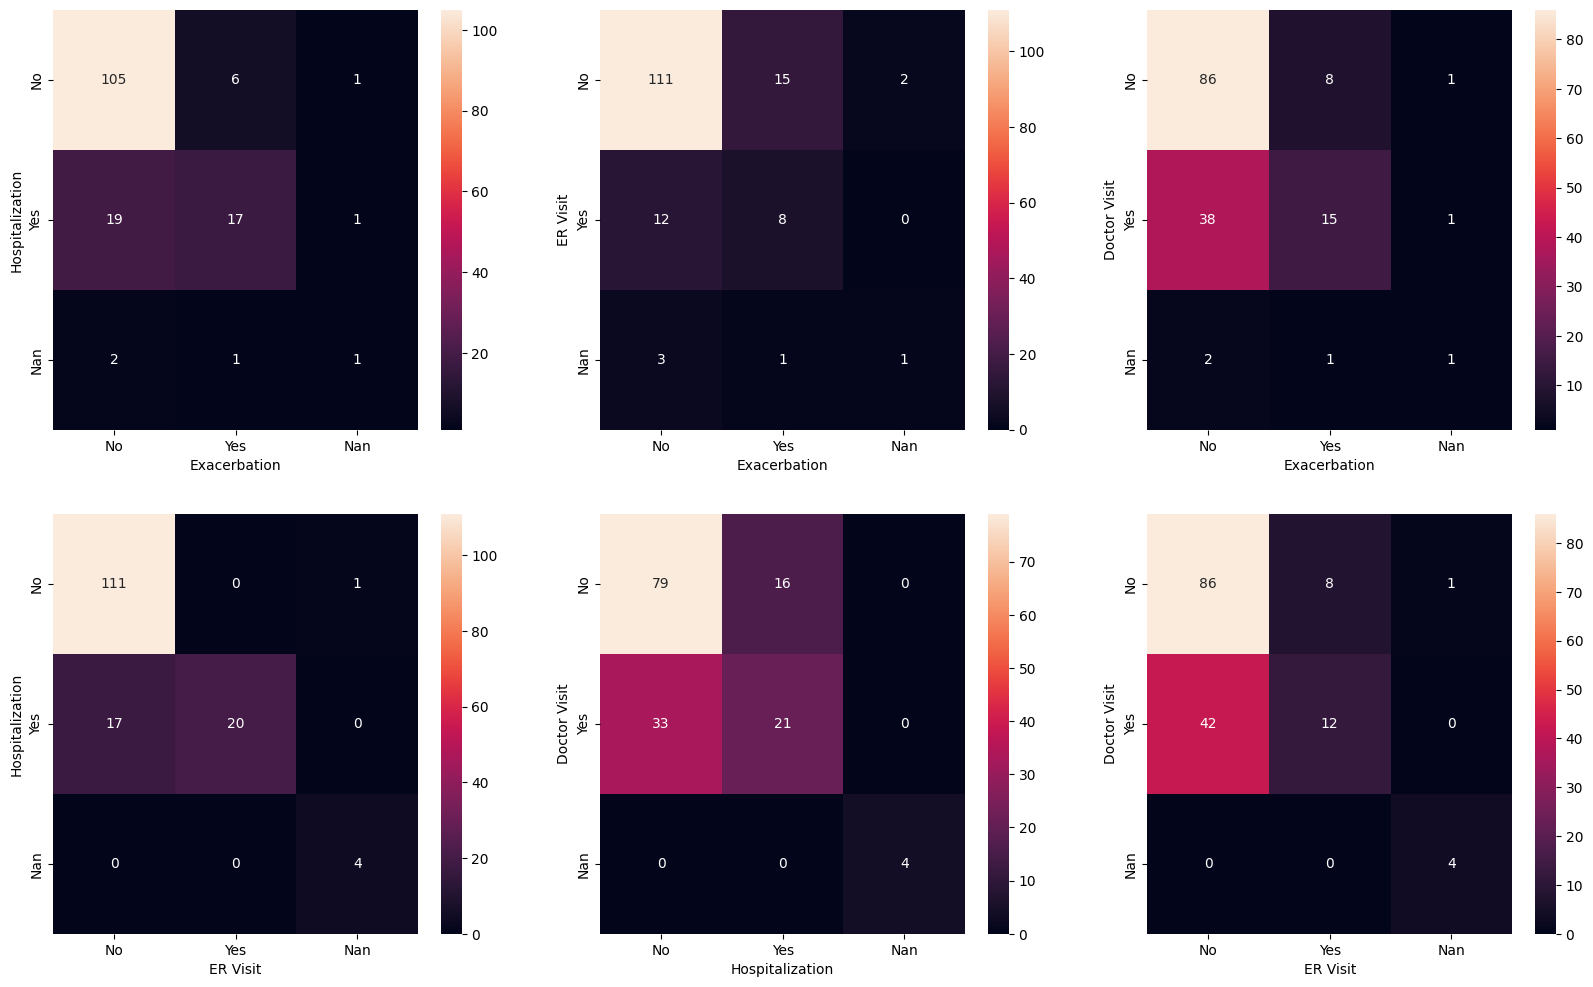

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# only get the target candidate columns
target_candidate_subset = harvard[['login', 'Assmnt', 'fclinra08', 'fclinicpt03', 'fclinpt04', 'fclinpt05', 'bclinra07']].copy()
# first find out when all these outcomes where tested in the study (do we have one observation at the end of the study for each patient?)

# get all the rows where Assmnt is 21
last_follow_ups = target_candidate_subset[target_candidate_subset['Assmnt'] == 21]
# print(len(last_follow_ups))

# if exacerbation happened make it 1, otherwise 0
last_follow_ups.loc[last_follow_ups['fclinra08'] == 2, 'fclinra08'] = 0

last_follow_ups.loc[last_follow_ups['fclinicpt03'] <2, 'fclinicpt03'] = 0
last_follow_ups.loc[last_follow_ups['fclinicpt03'] >= 2, 'fclinicpt03'] = 1

last_follow_ups.loc[last_follow_ups['fclinpt04'] < 2, 'fclinpt04'] = 0
last_follow_ups.loc[last_follow_ups['fclinpt04'] >= 2, 'fclinpt04'] = 1

last_follow_ups.loc[last_follow_ups['fclinpt05'] < 2, 'fclinpt05'] = 0
last_follow_ups.loc[last_follow_ups['fclinpt05'] >= 2, 'fclinpt05'] = 1

# if fclinpt04 is 1, then fclinicpt03 should be 1 as well (if a patient was in the ER they should also be counted as hospitalized)
last_follow_ups.loc[(last_follow_ups['fclinpt04'] == 1) & (last_follow_ups['fclinicpt03'] == 0), 'fclinicpt03'] = 1


# replace nan with the value 2
last_follow_ups = last_follow_ups.fillna(2)

# fig, axs = plt.subplots(1, 3)

print("doctor visit value counts"+str(last_follow_ups['fclinpt05'].value_counts()))


# create a confusion metrics for each of the outcomes and fclinra08
hosp_exa_sub = last_follow_ups[['fclinra08', 'fclinicpt03']]
hosp_exa_matrix = confusion_matrix(hosp_exa_sub['fclinicpt03'], hosp_exa_sub['fclinra08'])
# do not truncate print statements
er_exa_sub = last_follow_ups[['fclinra08', 'fclinpt04']]
er_exa_matrix = confusion_matrix(er_exa_sub['fclinpt04'], er_exa_sub['fclinra08'])

doctor_exa_sub = last_follow_ups[['fclinra08', 'fclinpt05']]
doctor_exa_matrix = confusion_matrix(doctor_exa_sub['fclinpt05'], doctor_exa_sub['fclinra08'])

hosp_er_sub = last_follow_ups[['fclinicpt03', 'fclinpt04']]
hosp_er_matrix = confusion_matrix(hosp_er_sub['fclinicpt03'], hosp_er_sub['fclinpt04'])
# print all records where fclinpt04 is 1 but fclinicpt03 is 0
hosp_doctor_sub = last_follow_ups[['fclinicpt03', 'fclinpt05']]
hosp_doctor_matrix = confusion_matrix(hosp_doctor_sub['fclinpt05'], hosp_doctor_sub['fclinicpt03'])

er_doctor_sub = last_follow_ups[['fclinpt04', 'fclinpt05']]
er_doctor_matrix = confusion_matrix(er_doctor_sub['fclinpt05'], er_doctor_sub['fclinpt04']) 

# plot all 6 confusion matrices
fig, axs = plt.subplots(2, 3)
sns.heatmap(hosp_exa_matrix, annot=True, ax=axs[0,0], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[0,0].set_ylabel('Hospitalization')
axs[0,0].set_xlabel('Exacerbation')
sns.heatmap(er_exa_matrix, annot=True, ax=axs[0,1], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[0,1].set_ylabel('ER Visit')
axs[0,1].set_xlabel('Exacerbation')
sns.heatmap(doctor_exa_matrix, annot=True, ax=axs[0,2], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[0,2].set_ylabel('Doctor Visit')
axs[0,2].set_xlabel('Exacerbation')
sns.heatmap(hosp_er_matrix, annot=True, ax=axs[1,0], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[1,0].set_ylabel('Hospitalization')
axs[1,0].set_xlabel('ER Visit')
sns.heatmap(hosp_doctor_matrix, annot=True, ax=axs[1,1], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[1,1].set_xlabel('Hospitalization')
axs[1,1].set_ylabel('Doctor Visit')
sns.heatmap(er_doctor_matrix, annot=True, ax=axs[1,2], yticklabels=['No', 'Yes', 'Nan'], xticklabels=['No', 'Yes', 'Nan'], fmt='d')
axs[1,2].set_xlabel('ER Visit')
axs[1,2].set_ylabel('Doctor Visit')

# make the figure large
fig.set_size_inches(20, 12)



From these confusion matrices we can see that hospitalization, ER visit and exacerbation are very similar and that we can probably impute missing exacerbation values using hospitalization and ER visits (although only few). Doctor visits cannot be used for imputation as this may introduce false positives. Below imputation will be performed. Dropping the remaining patients without a recorded target outcome (whether an exacerbation occured during the 3 months) may be better than imputing our target variable to avoid the risk of bias. 

In [7]:
harvard_preprocessed = harvard.copy()

# if exacerbation happend, make it 1 not 0
harvard_preprocessed.loc[harvard_preprocessed['fclinra08'] == 2, 'fclinra08'] = 0
harvard_preprocessed.loc[harvard_preprocessed['fclinicpt03'] == 1, 'fclinicpt03'] = 0
harvard_preprocessed.loc[harvard_preprocessed['fclinicpt03'] >= 2, 'fclinicpt03'] = 1
harvard_preprocessed.loc[harvard_preprocessed['fclinpt04'] == 1, 'fclinpt04'] = 0
harvard_preprocessed.loc[harvard_preprocessed['fclinpt04'] >= 2, 'fclinpt04'] = 1
harvard_preprocessed['fclinra08'].fillna(-1, inplace=True)
harvard_preprocessed['fclinicpt03'].fillna(-1, inplace=True)
harvard_preprocessed['fclinpt04'].fillna(-1, inplace=True)

# if fclinpt04 (ER visit) is 1 set fclinicpt03 (hospitalization) to 1
harvard_preprocessed.loc[(harvard_preprocessed['fclinpt04'] == 1), 'fclinicpt03'] = 1

# impute values where fclinra08 is Nan in harvard with 0 if fclinicpt03 is 0
harvard_preprocessed.loc[(harvard_preprocessed['fclinra08'] == -1) & (harvard_preprocessed['fclinicpt03'] == 0), 'fclinra08'] = 0

# impute values where fclinicpt03 is Nan in harvard with 1 if fclinicpt03 is 1
harvard_preprocessed.loc[(harvard_preprocessed['fclinicpt03'] == -1) & (harvard_preprocessed['fclinicpt03'] == 1), 'fclinicpt03'] = 1
# replace -1 values with na again
harvard_preprocessed.loc[harvard_preprocessed['fclinra08'] == -1, 'fclinra08'] = np.nan
harvard_preprocessed.loc[harvard_preprocessed['fclinicpt03'] == -1, 'fclinicpt03'] = np.nan
harvard_preprocessed.loc[harvard_preprocessed['fclinpt04'] == -1, 'fclinpt04'] = np.nan
# drop all rows where fclinra08 is Nan
harvard_preprocessed = harvard_preprocessed.dropna(subset=['fclinra08'])

We now want to look at the exacerbation outcome vs the cohort that the patients were in

      bclinra07  fclinra08  Assmnt
0           1.0        0.0       1
18          1.0        0.0       1
33          1.0        0.0       1
54          1.0        0.0       1
72          2.0        0.0       1
...         ...        ...     ...
2691        1.0        0.0       1
2720        3.0        0.0       1
2729        1.0        0.0       1
2756        1.0        0.0       1
2777        3.0        0.0       1

[150 rows x 3 columns]
1.0    90
3.0    51
2.0     9
Name: bclinra07, dtype: int64
0.0    126
1.0     24
Name: fclinra08, dtype: int64


<AxesSubplot: >

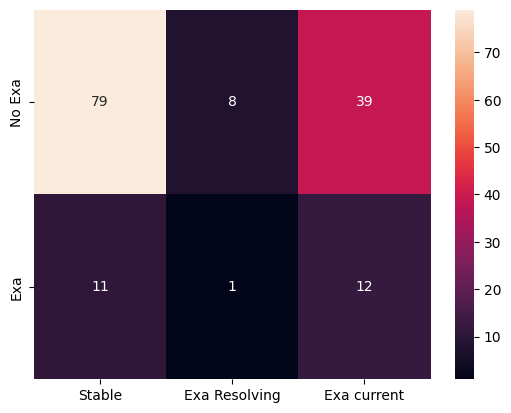

In [8]:
# create a confusion matrix for the 'bclinra07' cohorts and the 'fclinra08' outcome
cohort_sub = harvard_preprocessed[['bclinra07', 'fclinra08', 'Assmnt']].copy()
baseline_cohort = cohort_sub[cohort_sub['Assmnt'] == 1]
# filter by assessment
# replace Nan using -1
baseline_cohort = baseline_cohort.fillna(-1)
print(baseline_cohort)
print(baseline_cohort['bclinra07'].value_counts())
print(baseline_cohort['fclinra08'].value_counts())
# create my own confusion matrix. row 0 is no exacerbation, row 1 is exacerbation. Column 0 is stable, column 1 is resolving, column 2 is exacerbating
cohort_matrix = np.zeros((2, 3))
cohort_matrix[0, 0] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 1) & (baseline_cohort['fclinra08'] == 0)])
cohort_matrix[0, 1] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 2) & (baseline_cohort['fclinra08'] == 0)])
cohort_matrix[0, 2] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 3) & (baseline_cohort['fclinra08'] == 0)])
cohort_matrix[1, 0] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 1) & (baseline_cohort['fclinra08'] == 1)])
cohort_matrix[1, 1] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 2) & (baseline_cohort['fclinra08'] == 1)])
cohort_matrix[1, 2] = len(baseline_cohort[(baseline_cohort['bclinra07'] == 3) & (baseline_cohort['fclinra08'] == 1)])

# plot heatmap
fig, ax = plt.subplots()
sns.heatmap(cohort_matrix, annot=True, ax=ax, yticklabels=['No Exa', 'Exa'], xticklabels=['Stable', 'Exa Resolving', 'Exa current'])

We notice that whether a patient developed a new exacerbation to the study (row 1 and 2) does not seem to be included in the label at the beginning of the study (Stable, Exacerbation resolving, Exacerbation current). All subgroups seemed to develop exacerbations during the study and thus we need to consider all of these cohorts during the next steps and not only for example the people that were enrolled while having an exacerbation

## Missing values

As the Harvard dataset has 922 features, out of which only a small subset was satisfiably answered, we shall investigate what surveys are actually usable and which lack too many values.

In [9]:
# baseline dataframe has the same columns as the original dataset
import seaborn as sns

baseline = []
# create a follow up dataset (only the last record of each patient)
follow_up = []
for login in harvard_preprocessed['login'].unique():
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard_preprocessed[harvard_preprocessed['login'] == login].iloc[0])
    # if there is more than 1 record per login
    if len(harvard_preprocessed[harvard_preprocessed['login'] == login]) > 1:
        # add the last row of the selection to the follow up dataset
        follow_up.append(harvard_preprocessed[harvard_preprocessed['login'] == login].iloc[-1])
# turn lists into dataframes but with columns from harvard dataset
baseline_df = pd.DataFrame(baseline, columns=harvard_preprocessed.columns)

# look at all questionnaires except the follow up ones as they will naturally only have missing values when looking at the basleine dataframe
questionnaires = {"baseline_self_reported": baseline_self_reported, "baseline_research_assistant":baseline_research_assistant,  "demographics":demographics, "eligibility":eligibility, "facit":facit, "exact":exact, "anger":anger_survey, "anxiety":anxiety_survey, "depression":depression_survey, "fatigue":fatigue_survey, "pain":pain_survey, "globals":globals_survey, "phy_function":phy_function_survey, "social_satisfaction":social_satisfaction_survey, "psqi":psqi_survey, "sgrq":sgrq_survey, "other":other}



fig, axs = plt.subplots(4, 5, figsize=(100, 100))
fig.suptitle('Missing Values Percentage per Questionnaire for baseline harvard dataset', fontsize=50)
row = 0
col = 0
for label, questionnaire in questionnaires.items():    
    # if we are at the end of the row, move to the next row
    if col == 5:
        row += 1
        col = 0
    # get missing values per questionnaire
    missing_values_percentage = (baseline_df[questionnaire.columns].isna().sum() / unique_patients) * 100
    # if missing value percentag is smaller than 5% omit it
    # missing_values_percentage = missing_values_percentage[missing_values_percentage > 5]
    # rank the missing values percentage
    missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
    sns.barplot(x=missing_values_percentage.index, y=missing_values_percentage.values, ax=axs[row, col])
    # rotate x ticks
    axs[row,col].set_xticklabels(axs[row,col].get_xticklabels(), rotation=90)
    # set title
    axs[row,col].set_title(label)
    axs[row,col].set_ylabel('Missing values percentage')
    axs[row,col].set_xlabel('Question')
    # plot a line at 30% missing values
    axs[row,col].axhline(y=40, color='r', linestyle='-')
    # move to the next column
    col += 1



Upon closer inspection we notice:
* most questionnaires were answered more when considering only the baseline information. During follow up measurements less PROMIS questions were answered. This makes sense as the authors mention in their study protocol that only a few select PROMIS items were administered weekly while the complete PROMIS was prompted at baseline
* elegibility info was answered well except for question 2 and 3 regarding exacerbation (this might not be as important however as the research assistant classified all participants themselves later)
* in the facit questionnaire questions similar to "why" participants could not do something and then only provided 2 possibilities for answering were generally left out. Questions were you could reply with a rating i.e. 1 -5 were however answered much more. 
* for PROMIS measures like anger, depression, anxiety, fatigue, pain behaviour, pain interference, physical function and social satisfaction the effect of the algorithm of the computer adaptive test (CAT) system can be clearly noticed in the respective missing value plots. Generally the first question that is prompted has the lowest amount of missing values. The next questions offered to the patient depend on the answers of the previous questions. The algorithm administers more questions within the specific questionnaire bank, until a stop condition is reached (either specified measurement precision level according to US population statistics or 12 questions max. per bank). This is why some path dependence may ensue, resulting in a lot of missing values for some banks
* shortform (SF) items in the questionnaires were administered after the previously administered questions, if not done so already - explaining higher response rate for SF compared to non SF items
* Global health, PSQI (sleep) and SGRQ was answered more as all of these questions were prompted at baseline without CAT
* sgrq07 was not answered a lot because patients might not have had a respiratory attack during the last 4 weeks


Text(0, 0.5, 'Missing values percentage')

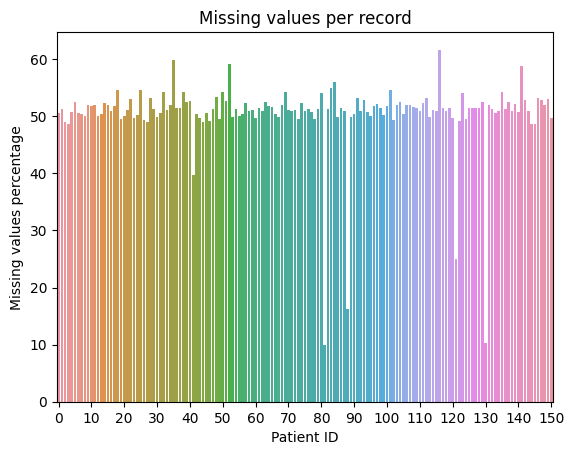

In [10]:
# create a plot of the missing values per record
missing_values_per_record = baseline_df.isna().sum(axis=1) / len(baseline_df.columns) * 100


sns.barplot(x=missing_values_per_record.index, y=missing_values_per_record.values)
plt.xticks(ticks=np.arange(0, len(baseline_df), 10), labels=np.arange(0, len(baseline_df), 10))
plt.title('Missing values per record')
plt.xlabel('Patient ID')
plt.ylabel('Missing values percentage')


We notice that the number of misssing values is more or less uniformly distributed across patients with a few patients that may have taken extra care to answer each question and 4 patient answering a few questions less than the others. Dropping patients would not be reasonable at this point. We should however drop patients that were not eligible due to a mental health disorder for example

In [11]:
# drop ineligible patients (where Elig10 == 2) because they are not deemed fit to answer the questions i.e. mental disorder
baseline_df_elig = baseline_df[baseline_df['Elig10'] != 2]

## Heuristic Feature Selection

In this section we reduce the initial 922 harvard features to a smaller subset based on a series of manual decisions. 

<b>How I'm deciding to drop variables</b>
* all variables not available at baseline (we only use the baseline values for prediction). These are the fclin variables except our target
* questions about events that occured in the last 2 months instead of 12 (these were usually not answered)
* "for how many days" questions (bclinpt29, bclinpt31, bclinpt33, bclinpt35, bclinpt37, bclinpt39, bclinpt42)
* "other symptoms": bclinpt41
* full text comments: bclinra09, bclinra10, psqi101
* variables we don't know the meaning of based on the data dictionary
* date and time variables: our classification should be independent from the date and time information
* redundant variables: multiple variables that carry the same or very similar information
* variables with little to no variance (i.e. eligibility variables because most records say they are eligible anyway)
* variables with more than 40% of missing values. This was chosen as an arbitrary threshold above which it might be difficult to impute values properly

### Dropping Irrelevant Columns

In [48]:
# drop login column
baseline_df = baseline_df_elig.drop(columns=['login'])

# get all variables that contain fclin
fclin_variables = [var for var in baseline_df.columns if 'fclin' in var]
# only keep our target variable ('exacerbations')
fclin_variables.remove('fclinra08')
# drop all other target candidate and follow up fclin variables
baseline_df = baseline_df.drop(columns=fclin_variables)
# drop an_bank variables (we don't know what they mean)
an_bank_varibles = pd.concat([baseline_df.filter(regex='An\d_Bank'),harvard.filter(regex='An\d{2}_Bank')])
baseline_df = baseline_df.drop(columns=an_bank_varibles.columns)

# variables that just are statistic values of the values entered into the questionnaires
# statistic_variables = [var for var in baseline_df.columns if ('Theta' in var or 'SE' in var)]
statistic_variables = ['dysp_theta', 'dysp_se', 'dysp_tscore', 'fl_theta', 'fl_se', 'fl_tscore', "nvalid_anx", "sf_dep8", "nvalid_dep", "sf_fatig7", "nvalid_fatig", "sf_painbe7", "nvalid_painbe", "sf_painin6", "nvalid_painin", "sf_phy10", "nvalid_phy", "sf_dsa7", "nvalid_dsa", "sf_sr7", "nvalid_sr", "nvalid_ph", "ph_t", "nvalid_mh", "mh_t", "sf_ang8", "nvalid_ang","sf_anx7" ]
baseline_df = baseline_df.drop(columns=statistic_variables)

# date and time variables
date_and_time = ['toflhadt', 'toflhadt02', 'bclinra01b', 'bclinra02b', 'bclinra05', 'bclinra13', 'bclinra15', 'bclinra17', 'psqi01', 'psqi03']
baseline_df = baseline_df.drop(columns=date_and_time)

# redundant and binarized variables (we rather believe the research assistant than the patient themselves)
redundant_variables = ["dem05_32", "dem05_16", "dem05_8", "dem05_4", "dem05_2", "dem05_1", "white", "dem08_128", "dem08_64", "dem08_32", "dem08_16", "dem08_8", "dem08_4", "dem08_2", "dem08_1", "agecat1", "bclinpt01", "bclinpt02", 'chart_bmi', 'sr_ft', 'sr_in', 'sr_ht', 'sr_bmi', 'sr_ht_cm', 'bclinpt02_kg', 'weight_diff', 'height_diff', ]

# "bclinpt43","bclinpt43_8192", "bclinpt43_4096", "bclinpt43_2048", "bclinpt43_1024", "bclinpt43_512", "bclinpt43_256", "bclinpt43_128", "bclinpt43_64", "bclinpt43_32", "bclinpt43_16", "bclinpt43_8", "bclinpt43_4", "bclinpt43_2", "bclinpt43_1", "bclinra06"
baseline_df = baseline_df.drop(columns=redundant_variables)

# variables that don't contribute to the model because all values are the same or variance is too small
non_contributing = ['Elig01', 'Elig04', 'Elig05', 'Elig06', 'Elig07', 'Elig08', 'Elig13','Elig10', 'Elig11', 'Elig12']
baseline_df = baseline_df.drop(columns=non_contributing)

# remove all questionnaire variables except the ones that are statistical outputs of the algorithm

# these are the variables we do not know the meaning of from the data dictionary
unknown_variables = ['GAC1', 'GAC2', 'grp', 'xsect', "sr_med14", "sr_med13", "sr_med12", "sr_med11", "sr_med10", "sr_med9", "sr_med8", "sr_med7", "sr_med6", "sr_med5", "sr_med4", "sr_med3", "sr_med2", "sr_med1", "mc_med14", "mc_med10", "mc_med9", "mc_med8", "mc_med7", "mc_med6", "mc_med5", "mc_med4", "mc_med3", "mc_med2", "mc_med1", "sr_dc", "sr_ab", "sr_ba", "sr_is", "sr_ss", "sr_ac", "mc_dc", "mc_ab", "mc_ba", "mc_is", "mc_ss", "mc_ac", "sleep6", "sleep7"]

baseline_df = baseline_df.drop(columns=unknown_variables)


others_to_drop = ['dem101', 'bclinpt35', 'bclinra18', 'bclinpt20', 'bclinpt25', 'bclinpt27', 'bclinpt29', 'bclinpt31', 'bclinpt33', 'bclinpt37', 'bclinpt39', 'bclinpt42', 'bclinpt41', 'HI7_Bank', 'HI12_Bank',  'bclinra201',
'Assmnt', 'Site', 'sTOFLHA', 'stofhla02', 'stofhla']

baseline_df = baseline_df.drop(columns=others_to_drop)

# store bclinpt44 and bclinpt45
bclinpt44 = baseline_df['bclinpt44']
bclinpt45 = baseline_df['bclinpt45']


# drop all columns with more than 40% missing values
baseline_df = baseline_df.dropna(thresh=baseline_df.shape[0]*0.6,axis=1)
# add bclinpt44 and bclinpt45 back (medication columns with a lot of missing values)
baseline_df = pd.concat([baseline_df, bclinpt44, bclinpt45], axis=1)


fig, axs = plt.subplots(4, 5, figsize=(100, 100))
fig.suptitle('Missing Values Percentage per Questionnaire for baseline harvard dataset', fontsize=50)
row = 0
col = 0
for label, questionnaire in questionnaires.items():    
    # if we are at the end of the row, move to the next row
    if col == 5:
        row += 1
        col = 0
    # remaining questionnaire columns
    remaining_columns = [col for col in baseline_df.columns if col in questionnaire.columns]
    # print(len(remaining_columns))
    # get missing values per questionnaire
    missing_values_percentage = (baseline_df[remaining_columns].isna().sum() / unique_patients) * 100
    # rank the missing values percentage
    missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
    sns.barplot(x=missing_values_percentage.index, y=missing_values_percentage.values, ax=axs[row, col])
    # rotate x ticks
    axs[row,col].set_xticklabels(axs[row,col].get_xticklabels(), rotation=90)
    # set title
    axs[row,col].set_title(label)
    axs[row,col].set_ylabel('Missing values percentage')
    axs[row,col].set_xlabel('Question')
    # plot a line at 40% missing values
    axs[row,col].axhline(y=40, color='r', linestyle='-')
    # move to the next column
    col += 1

print(len(baseline_df.columns))


303


## Dealing with medications

As medications are only partially binarized we need to come up with a scheme to fully binarize them and convert medications that were added in text form as additional medications to these binarized medications. We shall also investigate whether there is a mismatch between self reported medications and what the research assistant assigned the patients. 

In [55]:
baseline_df_meds = baseline_df.copy()

# check for differences between blcinpt43 (self reported) and bclinra06 (research assistant)
self_reported_meds = baseline_df_meds.filter(regex='bclinpt43')
# print(self_reported_meds.columns)
# self reported contains prednisone, azithromycin, and other antibiotic

# TODO process "other medication for self reported"

# print all unique values of bclinpt43
print(baseline_df_meds['bclinpt44'].unique())
print(baseline_df_meds['bclinpt45'].unique())

# create new columns for Advair, Erythromycin, levaquin, Azithromycin (z-pak, Azithromax), Doxycyclin, mometasone (azmanex, mometazone, athmanex),  Singulair (montelukast, singulair), oxygen (CPAP), xopenex (levalbuterol)
baseline_df_meds['Advair_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Advair', na=False), 'Advair_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Advair', na=False), 'Advair_pt'] = 1

baseline_df_meds['Erythromycin_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Erythromycin', na=False), 'Erythromycin_pt'] = 1
baseline_df_meds['Levaquin_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Levaquin', na=False), 'Levaquin_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('levaquin', na=False), 'Levaquin_pt'] = 1
baseline_df_meds['Azithromycin_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Z-Pak', na=False), 'Azithromycin_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Azithromax', na=False), 'Azithromycin_pt'] = 1
1
baseline_df_meds['Doxycyclin_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt44'].str.contains('Doxycyclin', na=False), 'Doxycyclin_pt'] = 1
baseline_df_meds['Mometasone_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('azmanex', na=False), 'Mometasone_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('asmanex', na=False), 'Mometasone_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Asthmanex', na=False), 'Mometasone_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('mometazone', na=False), 'Mometasone_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('mometasone', na=False), 'Mometasone_pt'] = 1
baseline_df_meds['Singulair_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('montelukast', na=False), 'Singulair_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Singulair', na=False), 'Singulair_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('singulair', na=False), 'Singulair_pt'] = 1
baseline_df_meds['Oxygen_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('CPAP', na=False), 'Oxygen_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('oxygen', na=False), 'Oxygen_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Oxygen', na=False), 'Oxygen_pt'] = 1
baseline_df_meds['Xopenex_pt'] = 0
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('levalbuterol', na=False), 'Xopenex_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Xopenex', na=False), 'Xopenex_pt'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('xopenex', na=False), 'Xopenex_pt'] = 1

# if bclinpt45 contains prednison set prednisone to 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('prednison', na=False), 'bclinpt43_1024'] = 1

# when symbicort set budesonide and formoterol to 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Symbicort', na=False), 'bclinpt43_128'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('Symbicort', na=False), 'bclinpt43_32'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('symbicort', na=False), 'bclinpt43_128'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinpt45'].str.contains('symbicort', na=False), 'bclinpt43_32'] = 1


ra_reported_meds = baseline_df_meds.filter(regex='bclinra06')
# change bclinra1024 to bclinra8192
ra_reported_meds = ra_reported_meds.rename(columns={'bclinra1024': 'bclinra8192'})
# add new columns bclinra1024 (prednisone), bclinra2048 (azithromycin), bclinra4096 (other antibiotic) to baseline_df_meds
baseline_df_meds['bclinra1024'] = 0
baseline_df_meds['bclinra2048'] = 0
baseline_df_meds['bclinra4096'] = 0
# print all unique values of bclinra06a
print("bclinra06")
print(ra_reported_meds['bclinra06a'].unique())


# if bclinra06a contains the word Prednisone set bclinra1024 to 1
baseline_df_meds.loc[baseline_df_meds['bclinra06a'].str.contains('Prednisone', na=False), 'bclinra1024'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinra06a'].str.contains('methylPrednisone', na=False), 'bclinra1024'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinra06a'].str.contains('predinisone', na=False), 'bclinra1024'] = 1
baseline_df_meds.loc[baseline_df_meds['bclinra06a'].str.contains('methylprednisolone', na=False), 'bclinra1024'] = 1

# if bclinra06a contains the word Azithromycin set bclinra2048 to 1
baseline_df_meds.loc[baseline_df_meds['bclinra06a'].str.contains('Azithromycin', na=False), 'bclinra2048'] = 1

# TODO 
# create unique values for mometasone, advair, oxygen, xopenex, 
# change performomist to formoterol, proair to albuterol


# get all patients where bclinra06a contains prednisone
prednisone = baseline_df[baseline_df['bclinra06a'].str.contains('Prednisone', na=False)]
# add 


# TODO investigate differences between self reported medication and research assistant reported medication

# print(ra_reported_meds.columns)

# TODO investigate number of medications per patient, antibiotic use in stable unstable exacerbator and non-exacerbator cohort (for this we need to binarize the other antibiotic column) or look deeper into other medication column
# also investigate prescribed inhaler or how they do it in the triage dataset

[nan 'Advair' 'Erythromycin' 'Levaquin' 'doxycycline'
 "patient doesn't know anti-biotic name" 'Z-Pak'
 'through IV unsure of name' 'V...' 'FosamaxchantixAdvair' 'Azithromax'
 'macrolide or placebo' 'levaquin']
['mometasone' nan 'Advair' 'mometasone furoate' 'allegra'
 'Advair Oxygen Singulair' 'singulair oxygen loritab' 'Advair CPAP'
 'Advair oxygen at night' 'mometazone' 'azmanex' 'oxygen'
 'Advair 250/50 Singulair' 'Advair oxygen' 'theophylline'
 'patient didnt know and didnt want to guess' 'Vytorin' 'Advair Diskus'
 'advair' 'Advair 250/50' 'Advair diskus' 'nebulizer' 'Zyflo Symbicort'
 'Asthmanex' 'Advair Xopenex' 'montelukast' 'xopenex' 'asmanex'
 'Advair Singulair Zyrtec' 'Advair/prednison' 'Advair nebulizer'
 'Advair Singulair flovent' 'Xopenex' 'symbicort' 'Advair and Singulair'
 'mometasone furate; theophylline']
bclinra06
['Mometasone' nan 'Advair Prednisone' 'Advair' 'Mometasone Furoate'
 'Advair Allegra' 'Advair Diskus' 'oxygen'
 'Azithromycin Mometasone Prednisone' 'Azith

## Feature Importance within Questionnaires

In order to be able to examine feature importance of the remaining variables we need to impute values so that Sklearn algorithms will work. First we will take a look at all the distributions before imputation so that we can later gauge how much they were changed after imputation. Before we can do this we need to convert any strings remaining in the data however

In [13]:
# convert scientific notation strings
sgrq_strings = baseline_df[['sgrq_sx_r', 'sgrq_act_r', 'sgrq_imp_r', 'sgrq_tot_r']]
# convert all sgrq_stats to strings
sgrq_strings = sgrq_strings.astype(str)
# replace , with .
sgrq_strings = sgrq_strings.apply(lambda x: x.str.replace(',','.'), axis=1)
# replace E with ''
sgrq_strings = sgrq_strings.apply(lambda x: x.str.replace('E',''), axis=1)
# split each string at E and take the first part (the number)
sgrq_strings = sgrq_strings.apply(lambda x: (pd.to_numeric(x.str.split('+').str[0], errors='coerce')), axis=1)

preprocessed_baseline_df = baseline_df.copy()
# replace sgrq_stats with the converted strings
preprocessed_baseline_df[['sgrq_sx_r', 'sgrq_act_r', 'sgrq_imp_r', 'sgrq_tot_r']] = sgrq_strings

In [14]:
import math

for label, questionnaire in questionnaires.items():
    # get all variables in baseline_self_reported
    variables = [col for col in preprocessed_baseline_df.columns if col in questionnaire.columns]
    # get the optimal height and width of the plot depending on the total number of variables
    height = math.ceil(math.sqrt(len(variables)))
    width = math.ceil(len(variables) / height)
    # create a figure with the optimal height and width
    fig, axs = plt.subplots(height, width, figsize=(width*10, height*10))
    # set the title of the figure
    col = 0
    row = 0
    # for each variable in baseline_self_reported
    for var in variables:
        # if we are at the end of the row, move to the next row
        if col == width:
            row += 1
            col = 0
        # plot the histogram
        preprocessed_baseline_df[var].hist(ax=axs[row, col])
        # set the title of the plot
        axs[row, col].set_title(var)
        # move to the next column
        col += 1

    # save figure to file
    fig.savefig('images/distributions_pre_imputation/{0}.png'.format(str(label+"_pre_imputation")))
    plt.clf()


<Figure size 5000x6000 with 0 Axes>

<Figure size 5000x6000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

<Figure size 3000x4000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 3000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

<Figure size 7000x8000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [15]:
# numerical variables are all variables in preprocessed df and in numerical variables above
numerical_variables = [col for col in preprocessed_baseline_df.columns if col in variable_types['Numeric']]
other_variables = [col for col in preprocessed_baseline_df.columns if col not in variable_types['Numeric']]
baseline_df_imputed = preprocessed_baseline_df.copy()
# impute numerical variables using KNN imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
baseline_df_imputed[numerical_variables] = imputer.fit_transform(preprocessed_baseline_df[numerical_variables])

# impute other variables using mode
baseline_df_imputed[other_variables] = preprocessed_baseline_df[other_variables].fillna(preprocessed_baseline_df[other_variables].mode().iloc[0])



In [16]:
for label, questionnaire in questionnaires.items():
    # get all variables in baseline_self_reported
    variables = [col for col in baseline_df_imputed.columns if col in questionnaire.columns]
    # get the optimal height and width of the plot depending on the total number of variables
    height = math.ceil(math.sqrt(len(variables)))
    width = math.ceil(len(variables) / height)
    # create a figure with the optimal height and width
    fig, axs = plt.subplots(height, width, figsize=(width*10, height*10))
    # set the title of the figure
    col = 0
    row = 0
    # for each variable in baseline_self_reported
    for var in variables:
        # if we are at the end of the row, move to the next row
        if col == width:
            row += 1
            col = 0
        # plot the histogram
        baseline_df_imputed[var].hist(ax=axs[row, col])
        # set the title of the plot
        axs[row, col].set_title(var)
        # move to the next column
        col += 1

    # save figure to file
    fig.savefig('images/distributions_post_imputation/{0}.png'.format(str(label)+"_post"))
    plt.clf()

<Figure size 5000x6000 with 0 Axes>

<Figure size 5000x6000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

<Figure size 2000x3000 with 0 Axes>

<Figure size 3000x4000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 3000x4000 with 0 Axes>

<Figure size 4000x4000 with 0 Axes>

<Figure size 4000x5000 with 0 Axes>

<Figure size 5000x5000 with 0 Axes>

<Figure size 7000x8000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

In [17]:
# calculate variable importance for all variables in baseline_df_imputed

# create 5 splits of the data
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# create a pipeline of Standard Scaler and Random Forest Classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=42))])
# get all variables in baseline_df_imputed
variables = [col for col in baseline_df_imputed.columns if col not in ['fclinra08']]
# get the target variable
target = baseline_df_imputed['fclinra08']
# create a dataframe to store the variable importance
variable_importance = pd.DataFrame(columns=['variable', 'importances_0', 'importances_1', 'importances_2', 'importances_3', 'importances_4'])
# set variables to the sorted variables
variable_importance['variable'] = sorted(variables)
k = 0
# for each split
for train_index, test_index in kf.split(baseline_df_imputed):
    # get the train and test sets
    X_train, X_test = baseline_df_imputed.iloc[train_index], baseline_df_imputed.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    # fit the pipeline
    pipeline.fit(X_train[variables], y_train)
    # get the roc auc score
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test[variables])[:,1])
    print(roc_auc)
    # get the variable importance
    importance = pipeline.named_steps['rf'].feature_importances_
    # print the 10 most important variables
    print(sorted(zip(importance, variables), reverse=True)[:10])

    # get the variable names
    variable_names = X_train[variables].columns
    # create a dataframe of the variable importance
    variable_importance_split = pd.DataFrame({'variable': variable_names, 'importances': importance})
    # sort by variable name
    variable_importance_split = variable_importance_split.sort_values(by=['variable'])
    # add the variable importance to the variable_importance dataframe
    variable_importance['importances_{0}'.format(k)] = variable_importance_split['importances'].values
    k += 1

# do not truncate the dataframe
pd.set_option('display.max_rows', None)

fig, axs = plt.subplots(4, 5, figsize=(100, 100))
fig.suptitle('Variable importance per Questionnaire in Harvard', fontsize=50)
row = 0
col = 0
for label, questionnaire in questionnaires.items():    
    # if we are at the end of the row, move to the next row
    if col == 5:
        row += 1
        col = 0
    importances_df = variable_importance[variable_importance['variable'].isin(questionnaire.columns)]
    # set the variable column to be the index
    importances_df = importances_df.set_index('variable')
    # only use column 2 - 5 to plot boxplot for each variable
    importances_df_no_var = importances_df.iloc[:, 2:]
    # transpose the dataframe
    importances_df_no_var = importances_df_no_var.transpose()
    # create boxplot for each variable label is the variable name
    sns.boxplot(data=importances_df_no_var, ax=axs[row, col] )
    # rotate x ticks
    axs[row,col].set_xticklabels(axs[row,col].get_xticklabels(), rotation=90)
    # set title
    axs[row,col].set_title(label)
    axs[row,col].set_ylabel('Gini Variable Importance')
    # scale the y axis to fit all plots
    axs[row,col].set_ylim(0, 0.1)
    axs[row,col].set_xlabel('Question')
    # plot a line at 30% missing values
    # move to the next column
    col += 1

0.5880681818181819
[(0.034449501372422336, 'bclinra202'), (0.03374079191693567, 'PROMISSocialSatSRBankv1_SE'), (0.029822487829348016, 'PROMISFatigueBankv1_SE'), (0.029061996889614992, 'bclinra202c_2'), (0.023524291610612823, 'PROMISAnxietyBankv1_SE'), (0.018784615481589814, 'PROMISFatigueBankv1_Theta'), (0.01627678900880357, 'bclinra204'), (0.015760036311776558, 'EDANX05_SF'), (0.015541781435457282, 'PROMISPhyFunctionBankv1_SE'), (0.013906918756206215, 'PROMISSocialSatDSABankv1_SE')]
0.68
[(0.029961688218272553, 'PROMISFatigueBankv1_Theta'), (0.02371696756203067, 'PROMISFatigueBankv1_SE'), (0.01856926919560664, 'PROMISPainImpactBankv1_SE'), (0.016961063817599157, 'bclinra204c_2'), (0.016639285786641804, 'exact10'), (0.016451254011810253, 'PROMISPhyFunctionBankv1_SE'), (0.016314058451500565, 'bclinra204'), (0.016252607745692253, 'EDANX05_SF'), (0.015192257635857607, 'PAINBE25_SF'), (0.015025482984608436, 'PROMISAngerBankv1_SE')]
0.436
[(0.027861517887754955, 'bclinra202c_2'), (0.0251591

Overall the variable importances are generally very low - which could be due to the fact that we are using a lot of variables overall. The Random Forest used will have a higher chance to select different subsets of features during fitting the more variable are provided, which can then lead to an overall smaller feature importance for each variable.

We notice that the aggregate statistic values seem to be more important or at least on par with the questions offered in the questionnaires using CAT. These values are the SE and Theta value for the Anger, Anxiety, Depression, Fatigue, Pain, Physical Function and Social Satisfaction. Interestingly a similar observation can be made about the final scores of the SGRQ questionnaire sgrq_act_r, sgrq_imp_r, sgrq_sx_r, sgrq_tot_r.

This result makes sense as the aggregate values of the questionnaires generally have higher variance and will not suffer from missing values as the other provided questions. 

In the following we shall remove non-aggregate values from the PROMIS questionnaires. For the SGRQ the removal of variables indicating cough, sputum and wheeze may need to be considered if we want to homogenize the Harvard and the Triage dataset. For now we will only take the final SGRQ variable however.

In [29]:
# drop any variables not containing SE or Theta from the anger, anxiety, depression, fatigue, pain, phy_function, social_satisfaction questionnaires
baseline_promis_reduced = baseline_df_imputed.copy()
promis_questionnaires = [anger_survey, anxiety_survey, depression_survey, fatigue_survey, pain_survey, phy_function_survey, social_satisfaction_survey]
for promis_questionnaire in promis_questionnaires:
    # get all variables in baseline_self_reported
    variables = [col for col in baseline_promis_reduced.columns if col in promis_questionnaire.columns]
    # print(variables)
    # get the variables not containing SE or Theta
    variables_to_drop = [var for var in variables if ('SE' not in var and 'Theta' not in var)]
    # drop the variables
    baseline_promis_reduced = baseline_promis_reduced.drop(columns=variables_to_drop)

# remove any sgrq variables that are not the final scores ('sgrq_sx_r', 'sgrq_act_r', 'sgrq_imp_r', 'sgrq_tot_r')
sgrq_to_drop = [var for var in baseline_promis_reduced.columns if ('sgrq' in var and var not in ['sgrq_sx_r', 'sgrq_act_r', 'sgrq_imp_r', 'sgrq_tot_r'])]
baseline_promis_reduced = baseline_promis_reduced.drop(columns=sgrq_to_drop)


for column in baseline_promis_reduced.columns:
    print(column)

dem02
dem03
dem04
dem05
socio06
Socio07
dem08
bclinpt04
bclinpt05
bclinpt06
bclinpt07
bclinpt08
bclinpt10
bclinpt11
bclinpt12
bclinpt12a
bclinpt13
bclinpt14
bclinpt15
bclinpt16
bclinpt17
bclinpt18
bclinpt19
bclinpt21
bclinpt22
bclinpt24
bclinpt26
bclinpt28
bclinpt30
bclinpt32
bclinpt34
bclinpt36
bclinpt38
bclinpt40
bclinra01
bclinra02
bclinra11
bclinra16
bclinra202
bclinra202b_2
bclinra202c_2
bclinra203b_2
bclinra203c_2
bclinra204b_2
bclinra204c_2
bclinra205b_2
fclinra08
elig09
bclinra203
bclinra204
bclinra205
bclinpt22_1
Elig02
Elig03
bclinpt03
bclinpt09
bclinra03
bclinra06_1024
bclinra06_512
bclinra06_128
bclinra06_64
bclinra06_32
bclinra06_16
bclinra06_8
bclinra06_4
bclinra06_2
bclinra06_1
bclinra07
GeneralHealth
Global02
Global03
Global04
Global05
Global06
Global07
Global08
Global09
Global10
PROMISAngerBankv1_SE
PROMISAngerBankv1_Theta
PROMISAnxietyBankv1_SE
PROMISAnxietyBankv1_Theta
PROMISDepressionBankv1_SE
PROMISDepressionBankv1_Theta
PROMISFatigueBankv1_SE
PROMISFatigueBankv1_T

Now we can look at the scatter plots of each variable

0.6298076923076923
0.4627329192546583
0.692
0.8974358974358975
0.47916666666666674
                                mean_importances
variable                                        
bclinra202c_2                           0.029699
PROMISPhyFunctionBankv1_SE              0.027058
bclinra204c_2                           0.027053
PROMISFatigueBankv1_Theta               0.024559
PROMISSocialSatSRBankv1_Theta           0.023789
PROMISPhyFunctionBankv1_Theta           0.022389
PROMISSocialSatSRBankv1_SE              0.022054
bclinra205                              0.021556
bclinra202                              0.021139
sgrq_sx_r                               0.019137
PROMISPainImpactBankv1_SE               0.018861
PROMISDepressionBankv1_SE               0.018782
bclinra204b_2                           0.016419
PROMISAngerBankv1_SE                    0.016214
PROMISFatigueBankv1_SE                  0.016037
PROMISAnxietyBankv1_SE                  0.015789
PROMISPainImpactBankv1_Theta       

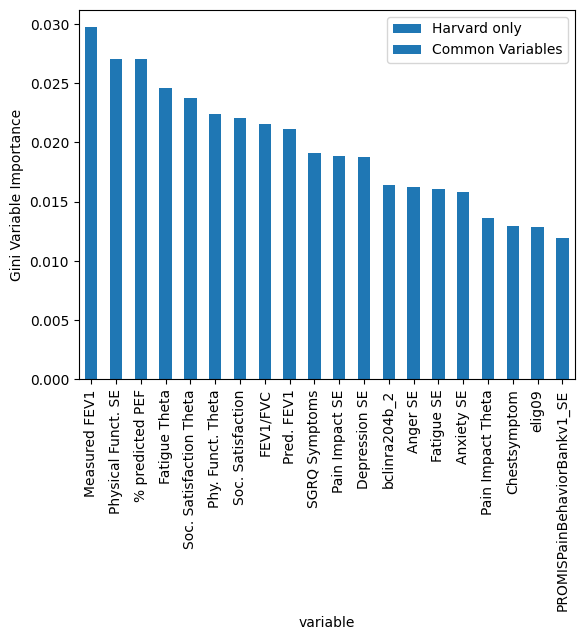

In [31]:
# create a new variable importance plot

# create 5 splits of the data
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
# create a pipeline of Standard Scaler and Random Forest Classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])
# get all variables in baseline_df_imputed
variables = [col for col in baseline_promis_reduced.columns if col not in ['fclinra08']]
# get the target variable
target = baseline_promis_reduced['fclinra08']
# create a dataframe to store the variable importance
variable_importance = pd.DataFrame(columns=['variable', 'importances_0', 'importances_1', 'importances_2', 'importances_3', 'importances_4'])
variable_importance['variable'] = sorted(variables)
k = 0
# for each split
for train_index, test_index in kf.split(baseline_promis_reduced):
    # get the train and test sets
    X_train, X_test = baseline_promis_reduced.iloc[train_index], baseline_promis_reduced.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    # fit the pipeline
    pipeline.fit(X_train[variables], y_train)
    # get the roc auc score
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test[variables])[:,1])
    print(roc_auc)
    # get the variable importance
    importance = pipeline.named_steps['rf'].feature_importances_
    

    # get the variable names
    variable_names = X_train[variables].columns
    # create a dataframe of the variable importance
    variable_importance_split = pd.DataFrame({'variable': variable_names, 'importances': importance})
    # sort by variable name
    variable_importance_split = variable_importance_split.sort_values(by=['variable'])
    # add the variable importance to the variable_importance dataframe
    variable_importance['importances_{0}'.format(k)] = variable_importance_split['importances'].values
    k += 1

mean_importances = pd.DataFrame({'variable': variable_importance['variable'], 'mean_importances': variable_importance.iloc[:, 1:].mean(axis=1)})
mean_importances = mean_importances.sort_values(by=['mean_importances'], ascending=False)
mean_importances = mean_importances.set_index('variable')

print(mean_importances)

# rename the index using rename_dict
mean_importances.rename(index=rename_dict, inplace=True)
# plot the top 20 variables
mean_importances[:20].plot.bar()
# use rename_dict to rename the variables

plt.bar([], [], label='Common Variables', color='orange')
# change labels in column to "Harvard only"(blue) and "Common" (orange)
plt.legend(['Harvard only', 'Common Variables'])
plt.ylabel('Gini Variable Importance')
# save figure to svg
plt.savefig('images/top20_variable_importance.svg', format='svg', dpi=1200)


## Condensing variables / columns

In [20]:
# medication columns
# race columns

In [21]:
# print the number of patients that have 2 or more values in the columns 

# print unique values in bclinpt44
print(baseline_df['bclinpt44'].unique())
# print unique values in bclinpt45
print(baseline_df['bclinpt45'].unique())

# create advair column
baseline_df['advair'] = 0
baseline_df['Levaquin'] = 0

medication_columns = ['bclinpt43',"bclinpt43_8192", "bclinpt43_4096", "bclinpt43_2048", "bclinpt43_1024", "bclinpt43_512", "bclinpt43_256", "bclinpt43_128", "bclinpt43_64", "bclinpt43_32", "bclinpt43_16", "bclinpt43_8", "bclinpt43_4", "bclinpt43_2", "bclinpt43_1", 'bclinpt44', 'bclinpt45','bclinra06', "bclinra06_1024", "bclinra06_512", "bclinra06_256", "bclinra06_128", "bclinra06_64", "bclinra06_32", "bclinra06_16", "bclinra06_8", "bclinra06_4", "bclinra06_2", "bclinra06_1",  ]

medications_df = baseline_df[medication_columns]
# export to csv
medications_df.to_csv('medications.csv', index=False, sep=";")

# # go through each row in the baseline dataset
# patients_with_medication = []
# for index, row in baseline_df.iterrows():
#     num_of_meds = 0
#     # go through each medication column
#     for col in medication_columns:
#         # if the value in the column is not null
#         if not pd.isnull(row[col]):
#             print(row[col])
#             # increase the number of medications by 1
#             num_of_meds += 1
#     if num_of_meds > 1:
#         patients_with_medication.append(row['login'])
# print(patients_with_medication)

KeyError: 'bclinpt44'

ValueError: Input y contains NaN.

# Variable Class Importance

Here we try to find out what class of variables (symptoms, medications, respiratory characteristics, sociodemografics) make sense to keep or remove

## Missing Value Imputation

In [ ]:
baseline_df = baseline_df.dropna(subset=['fclinra08'])

# get binary variables by finding the intersection of variable_types['Binary'] and baseline_df.columns
binary_variables = list(set(variable_types['Binary']).intersection(set(baseline_df.columns)))
# impute binary variables using mode
for var in binary_variables:
    baseline_df[var] = baseline_df[var].fillna(baseline_df[var].mode()[0])
# get categorical variables by finding the intersection of variable_types['Categorical'] and baseline_df.columns
categorical_variables = list(set(variable_types['Symbolic']).intersection(set(baseline_df.columns)))
# impute categorical variables using mode
for var in categorical_variables:
    baseline_df[var] = baseline_df[var].fillna(baseline_df[var].mode()[0])
# get numerical variables by finding the intersection of variable_types['Numerical'] and baseline_df.columns
numerical_variables = list(set(variable_types['Numeric']).intersection(set(baseline_df.columns)))
# impute numerical variables using median
for var in numerical_variables:
    baseline_df[var] = baseline_df[var].fillna(baseline_df[var].median())

In [ ]:
# create one large figure with the distribution for each variable after mv imputation
fig, axes = plt.subplots(10, 10, figsize=(100, 100))
for i, ax in enumerate(axes.flatten()):
    if i < len(baseline_df.columns):
        sns.histplot(baseline_df[baseline_df.columns[i]], ax=ax)
plt.show()

# TODO looks like we are introducing quite a bit of change in the underlying distribution of the data

## Target Variable

In [ ]:
# if target variable is 1 then set it to 0, otherwise 1
baseline_df.loc[baseline_df['fclinra08'] == 2, 'fclinra08'] = 0

# set all none 0 values to 1
baseline_df.loc[baseline_df['fclinra08'] == 1, 'fclinra08'] = 1



## Leave one variable class out feature importance

In [ ]:
# definition of categories of variables

symptoms = ['bclinpt28', 'bclinpt30', 'bclinpt32', 'bclinpt34', 'bclinpt36', 'bclinpt38', 'bclinpt40', 'Exact_total', 'Coughsputum', 'Chestsymptom']
medications = ['bclinra06_1024', 'bclinra06_512', 'bclinra06_128', 'bclinra06_64', 'bclinra06_32','bclinra06_16', 'bclinra06_8', 'bclinra06_4', 'bclinra06_2', 'bclinra06_1', 'bclinra09', 'bclinra10', ]
socio_demographics = ['dem02', 'dem03', 'dem04', 'dem05', 'socio06', 'Socio07','dem08', 'bclinra01', 'bclinra02' ]
respiratory_characteristics = ['bclinra101', 'bclinra102', 'bclinra103', 'bclinra104', 'bclinra202', 'bclinra202b_2', 'bclinra202b_5', 'bclinra202c_2', 'bclinra202c_5', 'bclinra203b_2', 'bclinra203b_5', 'bclinra203c_2', 'bclinra203c_5', 'bclinra204b_2', 'bclinra204b_5', 'bclinra205b_2', 'bclinra205b_2', 'bclinra203', 'bclinra204', 'bclinra205', 'facit_19', 'mmrc', 'bclinra205b_5']
copd_characteristics = ['bclinra08', 'bclinra11', 'bclinra14', 'bclinra16', 'elig09', 'Elig02','bclinra03']
history = ['bclinpt21', 'bclinpt22', 'bclinpt23', 'bclinpt24', 'bclinpt26' ]
psycho_somatic = ['bclinpt16', 'bclinpt17', 'EDANG30_Bank', 'EDANX53_Bank', 'EDDEP29_Bank', 'FATIMP3_Bank', 'PAININ9_Bank', 'PFC12_Bank', 'SRPSAT49_Bank', 'psqi']
comorbidities = ['bclinpt05', 'bclinpt06', 'bclinpt07', 'bclinpt08', 'bclinpt10', 'bclinpt11', 'bclinpt12', 'bclinpt12a', 'bclinpt13', 'bclinpt14', 'bclinpt15', 'bclinpt18', 'bclinpt19', 'bclinpt03', 'bclinpt09', 'GeneralHealth', 'Global02', 'Global04', 'Global05', 'Global06', 'Global07', 'Global08', 'Global09', 'Global10', 'bclinpt04']

# removed = baseline_df.drop(columns=symptoms+medications+socio_demographics+respiratory_characteristics+copd_characteristics+history+psycho_somatic+comorbidities)
# print(removed)



ROC AUC score without symptoms is 0.49846666666666667
ROC AUC score without medications is 0.5288666666666667
ROC AUC score without socio_demographics is 0.5325333333333333
ROC AUC score without respiratory_characteristics is 0.4636
ROC AUC score without copd_characteristics is 0.5105333333333333
ROC AUC score without history is 0.537
ROC AUC score without psycho_somatic is 0.5134666666666666
ROC AUC score without comorbidities is 0.5515333333333333


Text(0, 0.5, 'Variable category')

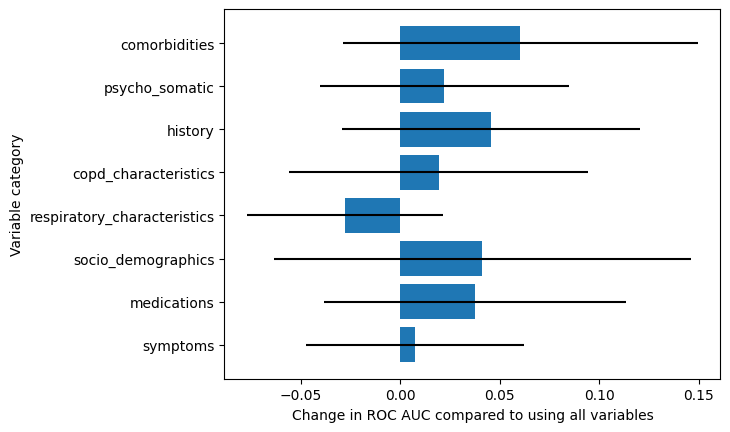

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# import standard scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
# import lazy predict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# do 100 fold cross validation using LightGBM
X = baseline_df.drop(columns=['fclinra08'])
y = baseline_df['fclinra08']

# # # first get the baseline
clf = LGBMClassifier()
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=8)
# # fit the model
# model, predictions = clf.fit(X_train, X_test, y_train, y_test)
# model


pipeline = make_pipeline(clf)
scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
default_score = np.mean(scores)

variable_classes = {'symptoms': symptoms, 'medications': medications, 'socio_demographics': socio_demographics, 'respiratory_characteristics': respiratory_characteristics, 'copd_characteristics': copd_characteristics, 'history': history, 'psycho_somatic': psycho_somatic, 'comorbidities': comorbidities}

importances_means = []
importances_std = []
# now perform leave one class out cross validation
for variable_class, variables in variable_classes.items():
    # remove the variables from the baseline_df
    baseline_df_reduced = baseline_df.drop(columns=variables)
    # get the X and y
    X = baseline_df_reduced.drop(columns=['fclinra08'])
    y = baseline_df_reduced['fclinra08']
    # do 5 fold cross validation using LightGBM
    clf = LGBMClassifier()
    pipeline = make_pipeline(clf)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    score = np.mean(scores)
    score_differences = np.abs(scores - default_score)
    variance = np.std(score_differences)
    print(f'ROC AUC score without {variable_class} is {score}')
    importances_means.append(score - default_score)
    importances_std.append(variance)
# create a horizontal barplot of the importances with the label being the variable class. Add error bars using the standard deviation. 
plt.barh(list(variable_classes.keys()), importances_means, xerr=importances_std)
# set x label is "change compared to using all variables"
plt.xlabel('Change in ROC AUC compared to using all variables')
# y label is "variable category"
plt.ylabel('Variable category')
# then remove one variable class at a time and see how the performance changes

In [ ]:
# get the type of variables per category

# vital signs

# sociodemographics


# medical history (especially important for EHR)

# bclinpt43, bclinpt44, bclinpt45, bclinra06, bclinra06a, bclinpt43_8192	bclinpt43_4096	bclinpt43_2048	bclinpt43_1024	bclinpt43_512	bclinpt43_256	bclinpt43_128	bclinpt43_64	bclinpt43_32	bclinpt43_16	bclinpt43_8	bclinpt43_4	bclinpt43_2	bclinpt43_1




# respiratory characteristics

# symptoms

# comorbidities

# lifestyle

# Preprocessing Pipeline

# Basic Structuring - old

In [ ]:

# drop all non relevant questions

# drop all columns containing socio
# harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='socio')))]

# drop demographics but do not drop dem02 and dem03
# dem02 = harvard['dem02']
# dem03 = harvard['dem03']
# harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='dem')))]
# harvard['dem02'] = dem02
# harvard['dem03'] = dem03

# drop elig except elig02, elig03, to maybe get rid of: elig10, elig11, elig12, 
elig02, elig03, elig10, elig11, elig12 = harvard['Elig02'], harvard['Elig03'], harvard['Elig10'], harvard['Elig11'], harvard['Elig12']
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Elig')))]
harvard['Elig02'], harvard['Elig03'], harvard['Elig10'], harvard['Elig11'], harvard['Elig12'] = elig02, elig03, elig10, elig11, elig12

# drop promis anger bank (EDANG)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDANG')))]

# drop promis anxiety bank (EDANX)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDANX')))]

# drop promis depression bank (EDDEP)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDDEP')))]
 
# drop promis fatigue bank (FATIMP)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FATIMP')))]

# drop promis pain behaviour bank (PAINBE)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PAINBE')))]

# drop promis pain impact bank (PAININ)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PAININ')))]

# drop promis physical function bank (PFA, PFB, PFC)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFA')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFB')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFC')))]

# promis social sat DSA bank (SRPSAT)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='SRPSAT')))]

# promis social (SRPSAT)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='SRPSOC')))]

# drop PSQI
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PSQI')))]

# drop toflh
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='TOFLH')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='toflh')))]

# drop FATEXP
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FATEXP')))]

# drop BLIN, FLIN, Assmnt, Site
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='BLIN')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FLIN')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Assmnt')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Site')))]

# only keep the final sgrq score
sgrq_tot = harvard['sgrq_tot_r']
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='sgrq')))]
harvard['sgrq_tot_r'] = sgrq_tot


# drop all columns that are mostly empty

# TODO think about BCLIN3, BLIN4, "FCLINC", "BCLIN2" (contains two medication values)

# harvard = harvard.drop(columns=["FCLINB", "FCLINA",  "FCLIN9", "FCLIN7", "FCLIN4", "FCLIN2", "fclinra52", "FCLIN1", "BCLIN1", "BCLIN0", "FCLIN8", "FCLIN6", "FCLIN5", "FCLIN3", "BCLIN5", "BCLIN4", "BCLIN3", "FCLINC", "BCLIN2", "SGRQ11", "Unnamed: 949", "Unnamed: 950" ])

# drop all remaining columns containing "Bank" 
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Bank')))]

# drop dates
harvard = harvard.drop(columns=["bclinra01b", "bclinra02b", "bclinra05", "bclinra13", "bclinra15", "bclinra17"])

print(harvard.shape)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_27100\3018542316.py:1: DtypeWarning: Columns (3,26,218,247,251) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv("data/Original Data/original_data.csv", sep=";")


(2796, 926)
(2796, 336)


In [ ]:
# contradicting values in the data:
    # where patient enters values differently in different columns

# impossible values in the data:
    # check physiological values



In [ ]:
# create a baseline dataset (only the first record of each patient)

# get all unique values in the login column
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
# create a follow up dataset (only the last record of each patient)
follow_up = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])

    # if there is more than 1 record per login
    if len(harvard[harvard['login'] == login]) > 1:
        # add the last row of the selection to the follow up dataset
        follow_up.append(harvard[harvard['login'] == login].iloc[-1])
# turn lists into dataframes but with columns from harvard dataset
baseline_df = pd.DataFrame(baseline, columns=harvard.columns)
follow_up_df = pd.DataFrame(follow_up, columns=harvard.columns)

# export baseline dataset
baseline_df.to_csv('baseline.csv', sep=";", index=False)
follow_up_df.to_csv('follow_up.csv', sep=";", index=False)
    


# Feature Space

NameError: name 'harvard' is not defined

### Difference between stable and unstable patients

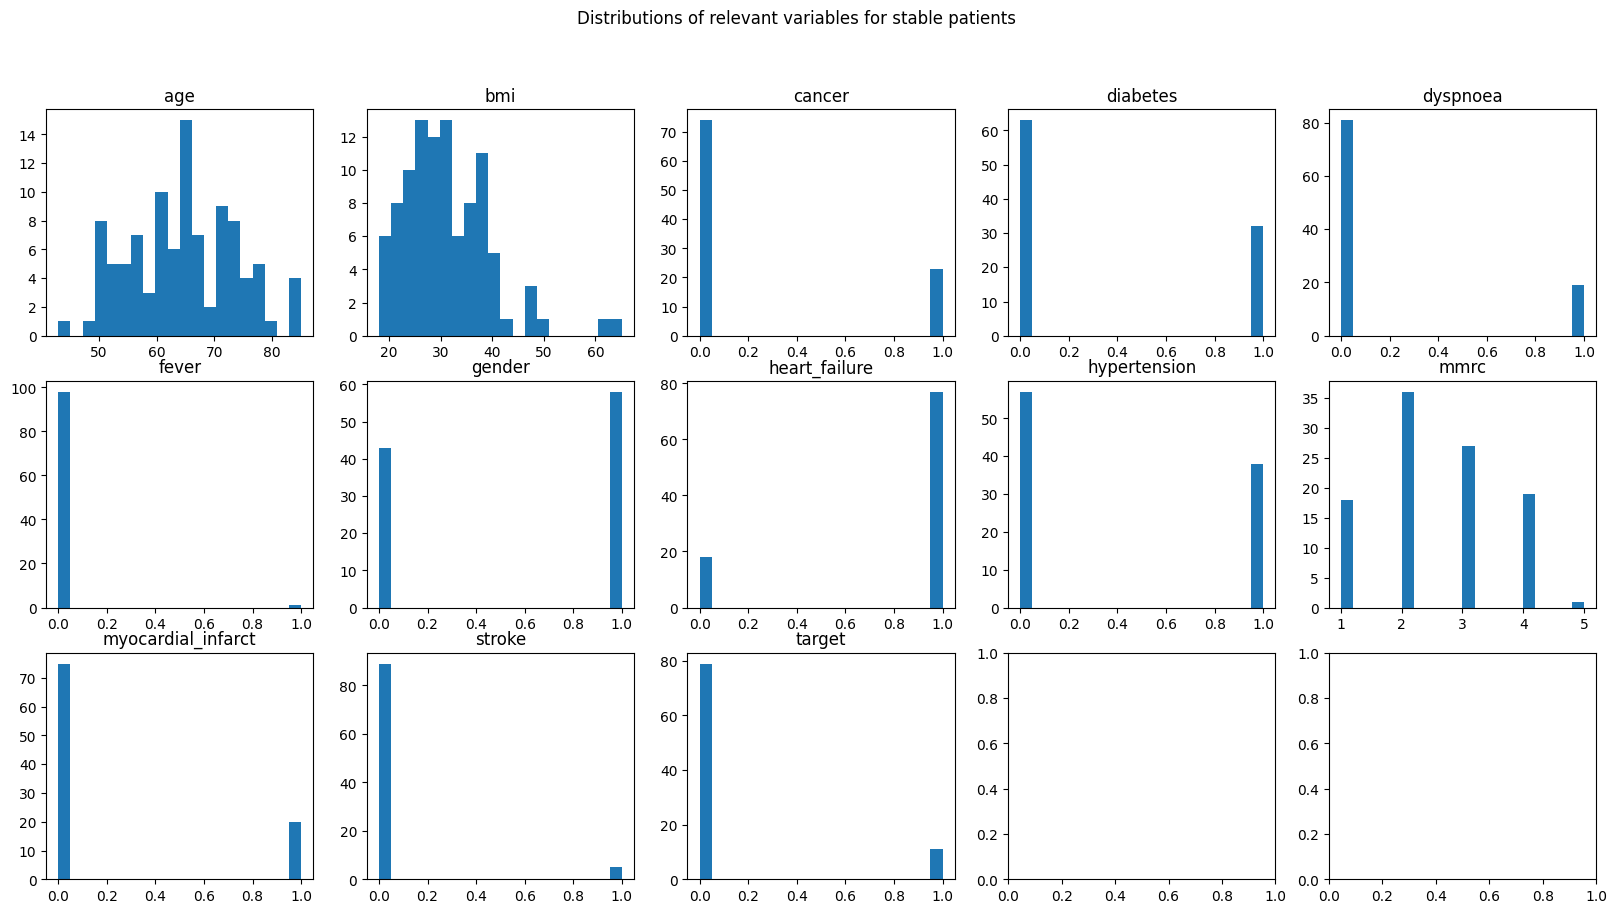

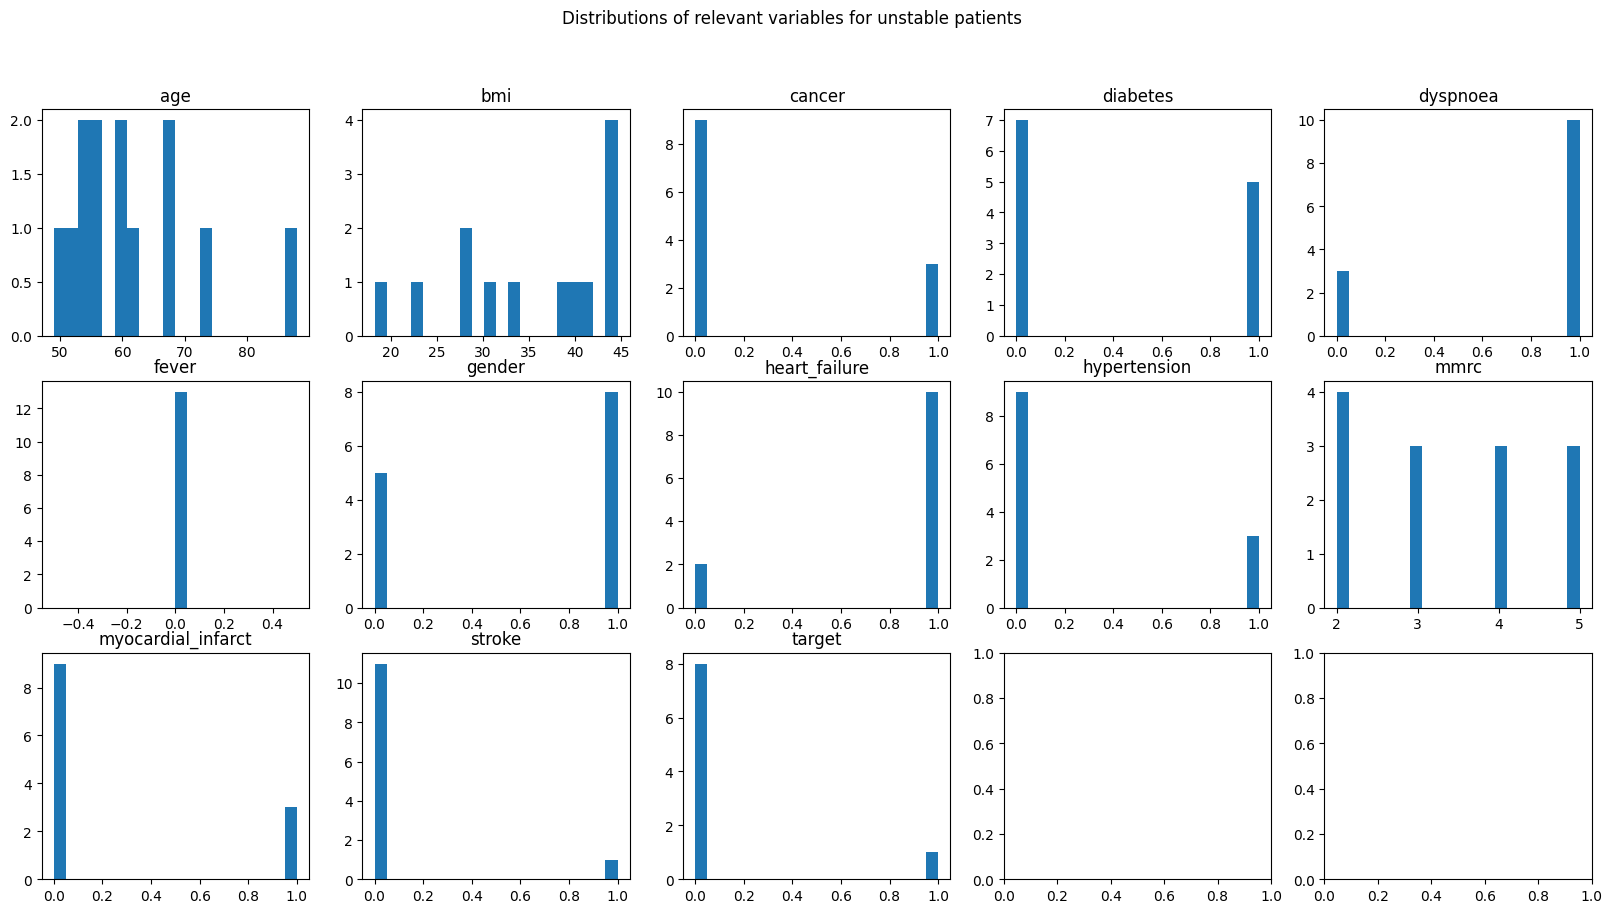

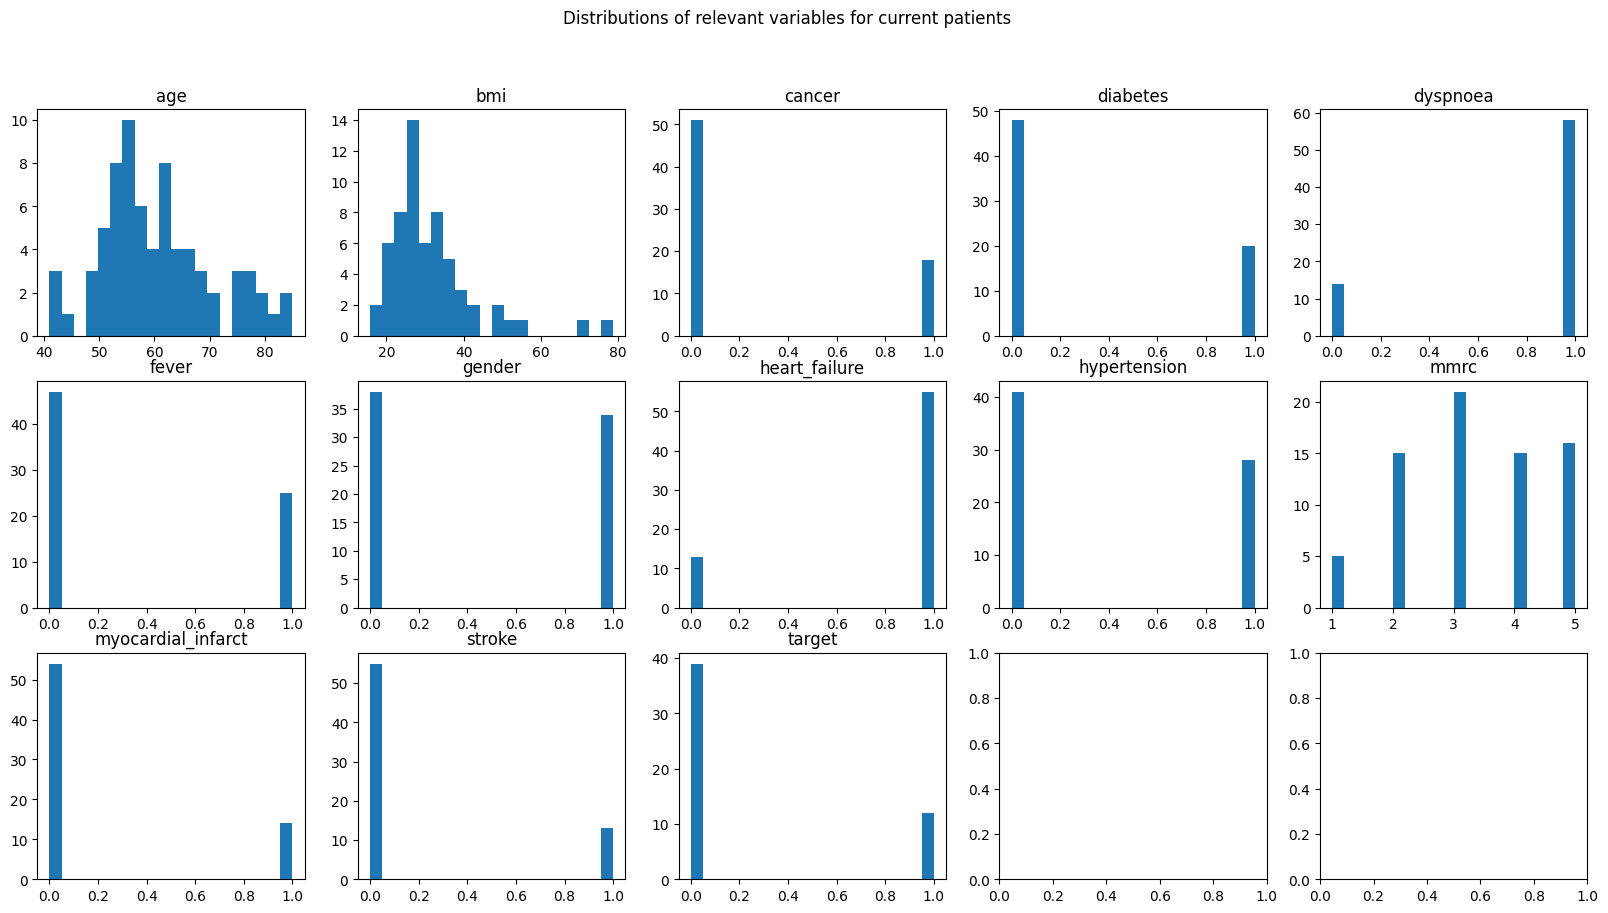

In [ ]:
harvard = baseline_df

# TODO look at exacerbation resolving and exacerbation current and follow up vs baseline

# relevant variables

# 
relevant_vars = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34',  'bclinpt28',  'bclinpt19', 'bclinpt08','bclinpt09', 'bclinra07', 'fclinra08']

exploration = harvard[relevant_vars]
exploration = exploration.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure','bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing', 'mmrc': 'mmrc', 'bclinpt22': 'prev_exacerb', 'fclinra08':'target'
 }) 

# modify features
# make female 0 and male = 1
exploration.loc[exploration['gender'] == 2, 'gender'] = 0
exploration.loc[exploration['gender'] == 1, 'gender'] = 1

exploration['hypertension'] = 1 - exploration['hypertension']
exploration['fever'] = 1 - exploration['fever']
exploration['heart_failure'] = 1- exploration['heart_failure']
exploration['dyspnoea'] = 1 - exploration['dyspnoea']

exploration['target'] = exploration['target'] - 1
exploration['target'] = 1 - exploration['target']

# calculate bmi from weight and height
exploration['bmi'] = exploration['weight'] / (exploration['height'] / 100) ** 2
exploration = exploration.drop(columns=['weight', 'height'])
exploration = exploration.reindex(sorted(exploration.columns), axis=1)

# get all stable patients
stable = exploration[exploration['bclinra07'] == 1]
stable = stable.drop(columns=['bclinra07'])
# create a 3x5 grid of plots for the distributions of the relevant variables
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle('Distributions of relevant variables for stable patients')
# loop through all relevant variables
for i, var in enumerate(stable.columns):
    # get the row and column index of the current variable
    row = i // 5
    col = i % 5
    # plot the distribution of the current variable
    axes[row, col].hist(stable[var], bins=20)
    axes[row, col].set_title(var)



# get all unstable patients
resolving = exploration[exploration['bclinra07'] == 2]
resolving = resolving.drop(columns=['bclinra07'])
# create a 3x5 grid of plots for the distributions of the relevant variables
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle('Distributions of relevant variables for unstable patients')
# loop through all relevant variables
for i, var in enumerate(resolving.columns):
    # get the row and column index of the current variable
    row = i // 5
    col = i % 5
    # plot the distribution of the current variable
    axes[row, col].hist(resolving[var], bins=20)
    axes[row, col].set_title(var)

current = exploration[exploration['bclinra07'] == 3]
current = current.drop(columns=['bclinra07'])
# create a 3x5 grid of plots for the distributions of the relevant variables
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
fig.suptitle('Distributions of relevant variables for current patients')
# loop through all relevant variables
for i, var in enumerate(current.columns):
    # get the row and column index of the current variable
    row = i // 5
    col = i % 5
    # plot the distribution of the current variable
    axes[row, col].hist(current[var], bins=20)
    axes[row, col].set_title(var)

plt.show()


C:\Users\Daniel\AppData\Local\Temp\ipykernel_9028\2873660330.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling
C:\Users\Daniel\AppData\Local\Temp\ipykernel_9028\2873660330.py:5: DtypeWarning: Columns (24,157,481,483,484,486,487,503) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/dropped_variables.csv", sep=";")


COPD_group
ER_12m
ER_3m
doctor_3m
exa_12m
exa_2m
exa_in_study
hosp_12m
hosp_3m
stability_assistant
stability_physician


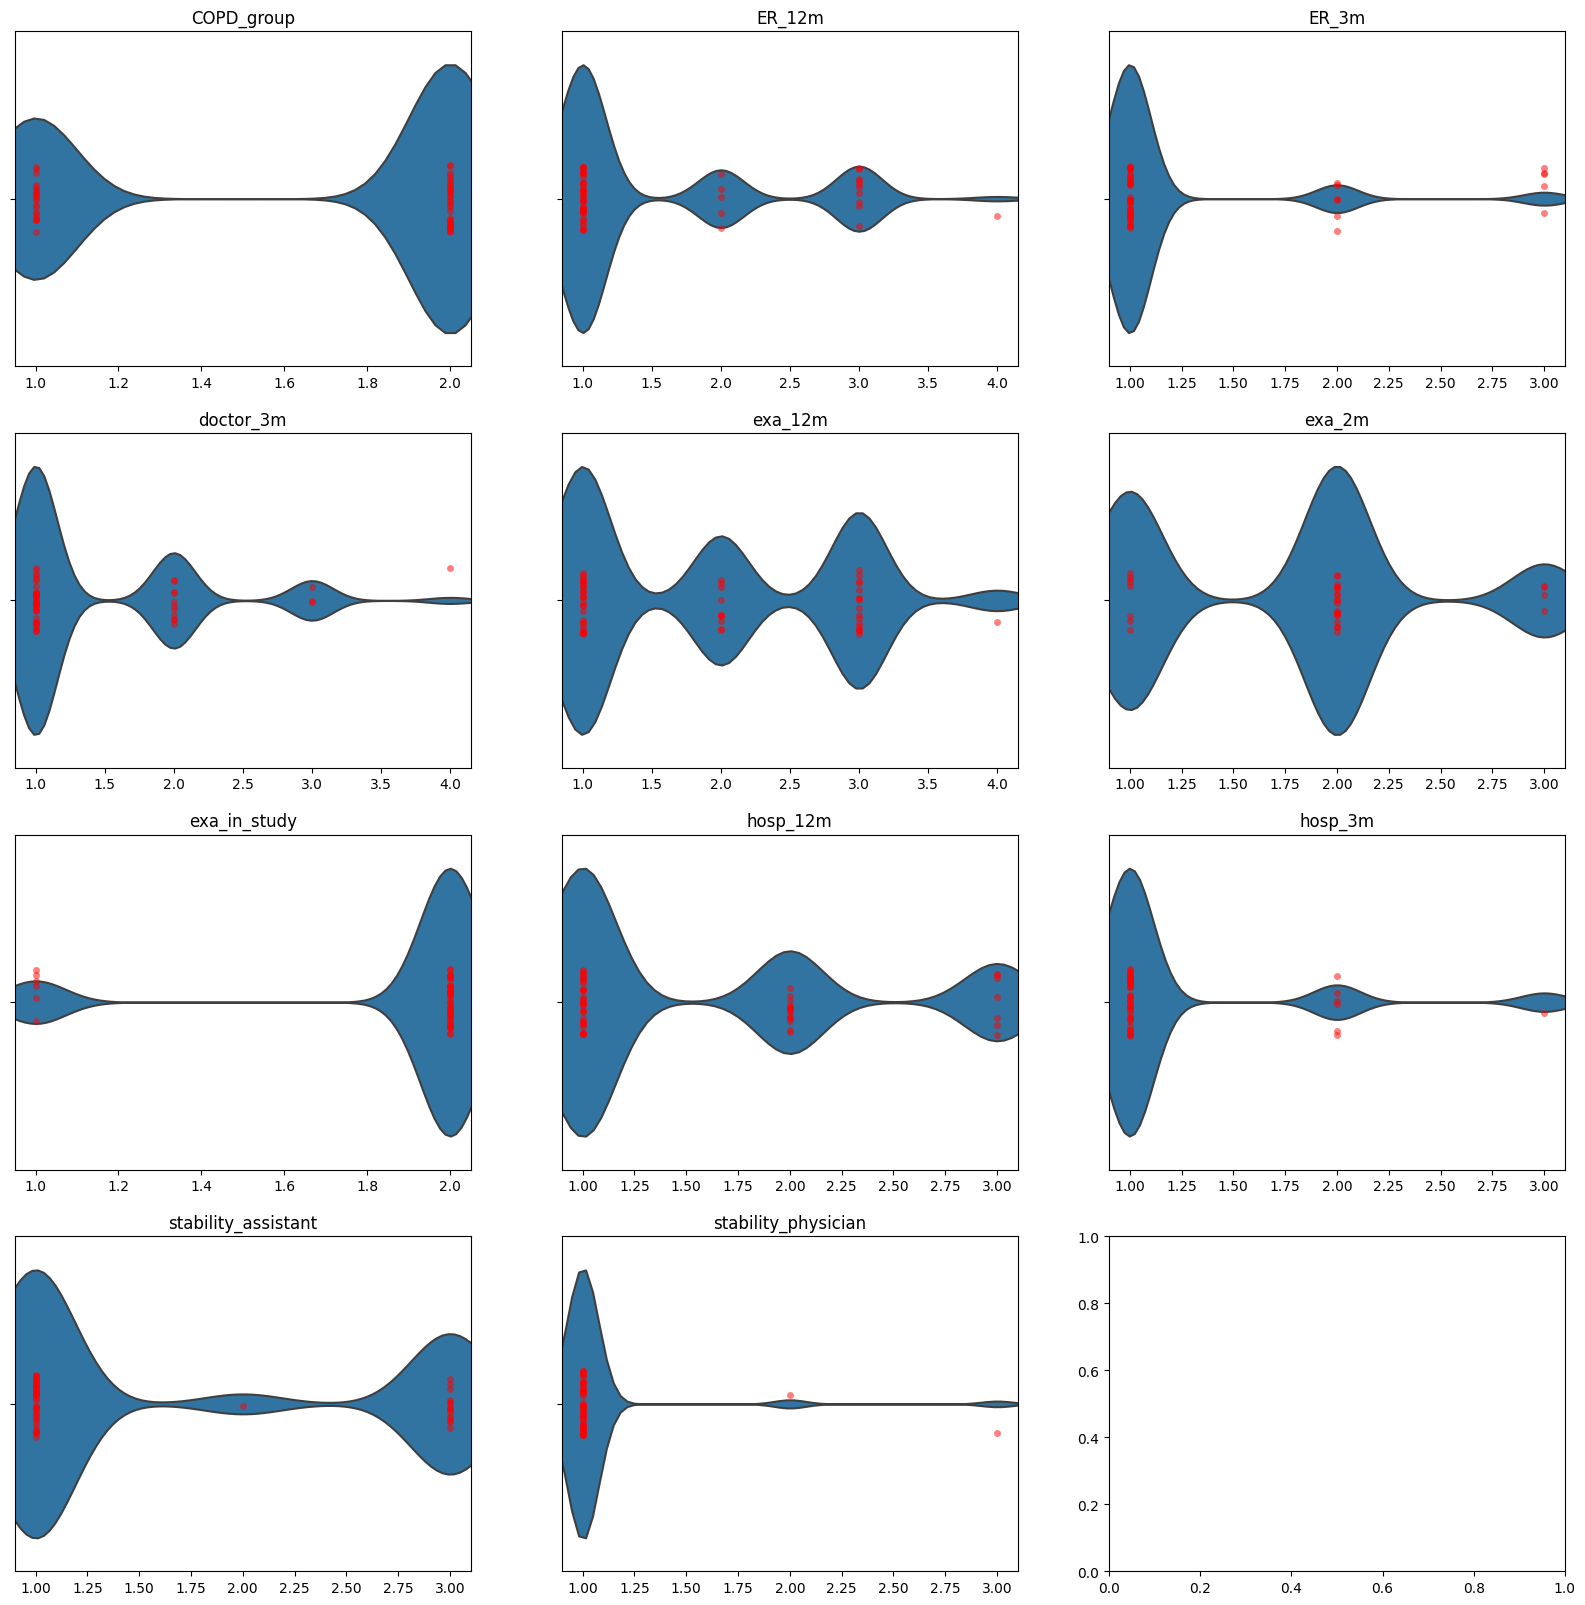

In [ ]:
import pandas as pd
import pandas_profiling

# investigate the correlations between all the possible target variables
data = pd.read_csv("data/dropped_variables.csv", sep=";")
target_vars = ["fclinra08", "bclinra07", "fclinra02", "fclinicpt03", "fclinpt04", "fclinpt05", "bclinpt24", "bclinpt26", "bclinpt22", "bclinpt23", "bclinra16"]
# create new dataframe with only target variables
targets_only = data[target_vars]
targets_only = targets_only.rename(columns={"fclinra08":"exa_in_study", "bclinra07":"stability_assistant", "fclinra02":"stability_physician", "fclinicpt03":"hosp_3m", "fclinpt04":"ER_3m", "fclinpt05":"doctor_3m", "bclinpt24":"hosp_12m", "bclinpt25":"hosp_2m", "bclinpt26":"ER_12m", "bclinpt27":"ER_2m", "bclinpt22":"exa_12m", "bclinpt23":"exa_2m", "bclinra16":"COPD_group"})
# sort columns
targets_only = targets_only.reindex(sorted(targets_only.columns), axis=1)

# # generate pandas profiling report with phik, spearman and pearson correlations
# report = pandas_profiling.ProfileReport(targets_only, correlations={"cramers": {"calculate": False}, "phi_k": {"calculate": True}, "spearman": {"calculate": True}, "pearson": {"calculate": True}})
# report.to_file("report_target_correlations.html")

# plot scatter plots between all pairs of target variables
# import seaborn as sns
# %matplotlib inline
# import matplotlib.pyplot as plt
# sns.pairplot(targets_only)
# plt.show()

# plot large vertical violin plots with samples superimposed for each target variable in one figure
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
# create figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
# iterate through all target variables
for i, target in enumerate(targets_only.columns):
    print(target)

    # get the current axis
    ax = axes[i//3, i%3]
    # plot violin plot withouth samples
    sns.violinplot(x=targets_only[target], ax=ax, inner=None)
    # remove 90% of the samples for each category
    reduced = targets_only[target].sample(frac=0.02)
    # show swarmplot
    # sns.swarmplot(x=targets_only[target], ax=ax, color="red", size=0.5)

    # plot samples using stripplot. Use entire height of the violin plot
    sns.stripplot(x=reduced, ax=ax, size=5, jitter=True, color="red", alpha=0.5)
    # only show ax title
    ax.set_xlabel("")

    # set title
    ax.set_title(target)
# save as svg
plt.savefig("images/harvard_targets_violin_plots.svg", format="svg")

# Preprocessing

In [ ]:
# simple preprocessing like in Triage, Exaggerate
target = 'fclinra08' #'bclinpt24'

harvard = baseline_df

relevant_vars = harvard.columns
# ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34',   'bclinpt28', target] #bclinpt19 (cancer), 'bclinpt36' fast breathing, 'bclinpt08', 'bclinpt09',

# load harvard dataset
harvard = harvard[relevant_vars]

# change mmrc by starting at 0 instead of 1
harvard['mmrc'] = harvard['mmrc'] - 1

# change gender by starting at 0 instead of 1
harvard['dem03'] = harvard['dem03'] - 1

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', target: 'target', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing',
 }) 
# print(harvard)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']
harvard['diabetes'] = 1 - harvard['diabetes']
harvard['heart_failure'] = 1 - harvard['heart_failure']
harvard['fever'] = 1 - harvard['fever']
# harvard['fast_breathing'] = 1 - harvard['fast_breathing']

# calculate bmi from weight and height
harvard['bmi'] = harvard['weight'] / (harvard['height'] / 100) ** 2
harvard = harvard.drop(columns=['weight', 'height'])
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

# plot_hist(harvard)

##########
# Missing Values & duplicates
##########

# remove all duplicate rows
# print("number of duplicates: " + str(harvard.duplicated().sum()))
harvard = harvard.drop_duplicates()
# print("number of duplicates after removal: " + str(harvard.duplicated().sum()))


# TODO try different imputation methods

numerical_vars = ['age', 'bmi']
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())


# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['gender', 'hypertension', 'diabetes', 'heart_failure', 'target', 'mmrc', 'fever',   'dyspnoea'] # cancer, 'fast_breathing','myocardial_infarct','stroke', 
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Outliers
##########

# TODO deal with outliers

##########
# Feature engineering
############




# print("feature engineering")

# plot_hist(harvard)

##########
# Normalization
##########

numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)


###########
# Target variable
###########

# print(harvard['target'].value_counts())
# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['target'] == 1, 'target'] = 0
# set all none 0 values to 1
harvard.loc[harvard['target'] != 0, 'target'] = 1
# print(harvard['target'].value_counts())

# use smote to rebalance the harvard dataset in place
# print("perform smote")

harvard = harvard.drop(columns=['bclinpt02_kg', 'chart_bmi', 'height_diff', 'sgrq_tot_r', 'sr_bmi', 'sr_ht_cm', 'weight_diff', 'bclinpt02', 'bclinpt41'])
# go through every columns
for col in harvard.columns:
    # check if any of the records contain an E
    for i in range(len(harvard[col])):
        if 'E' in str(harvard[col][i]):
            print(col)
            print(harvard[col][i])
            # if so, drop the column
            harvard = harvard.drop(columns=[col])
            break
        break

# convert all categorical variables to numeric using cat codes
for col in harvard.columns:
    if harvard[col].dtype == 'object':
        harvard[col] = harvard[col].astype('category')
        harvard[col] = harvard[col].cat.codes

# impute missing values using median
for col in harvard.columns:
    harvard[col] = harvard[col].fillna(harvard[col].median())

# drop the columns that still contain missing values
harvard = harvard.dropna(axis=1)
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
# X_res['target'] = y_res
# harvard = X_res

# print(harvard['target'].value_counts())

# print("scaling, target variable, smote")

# plot_hist(harvard)


# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Us

AttributeError: 'int' object has no attribute 'write'

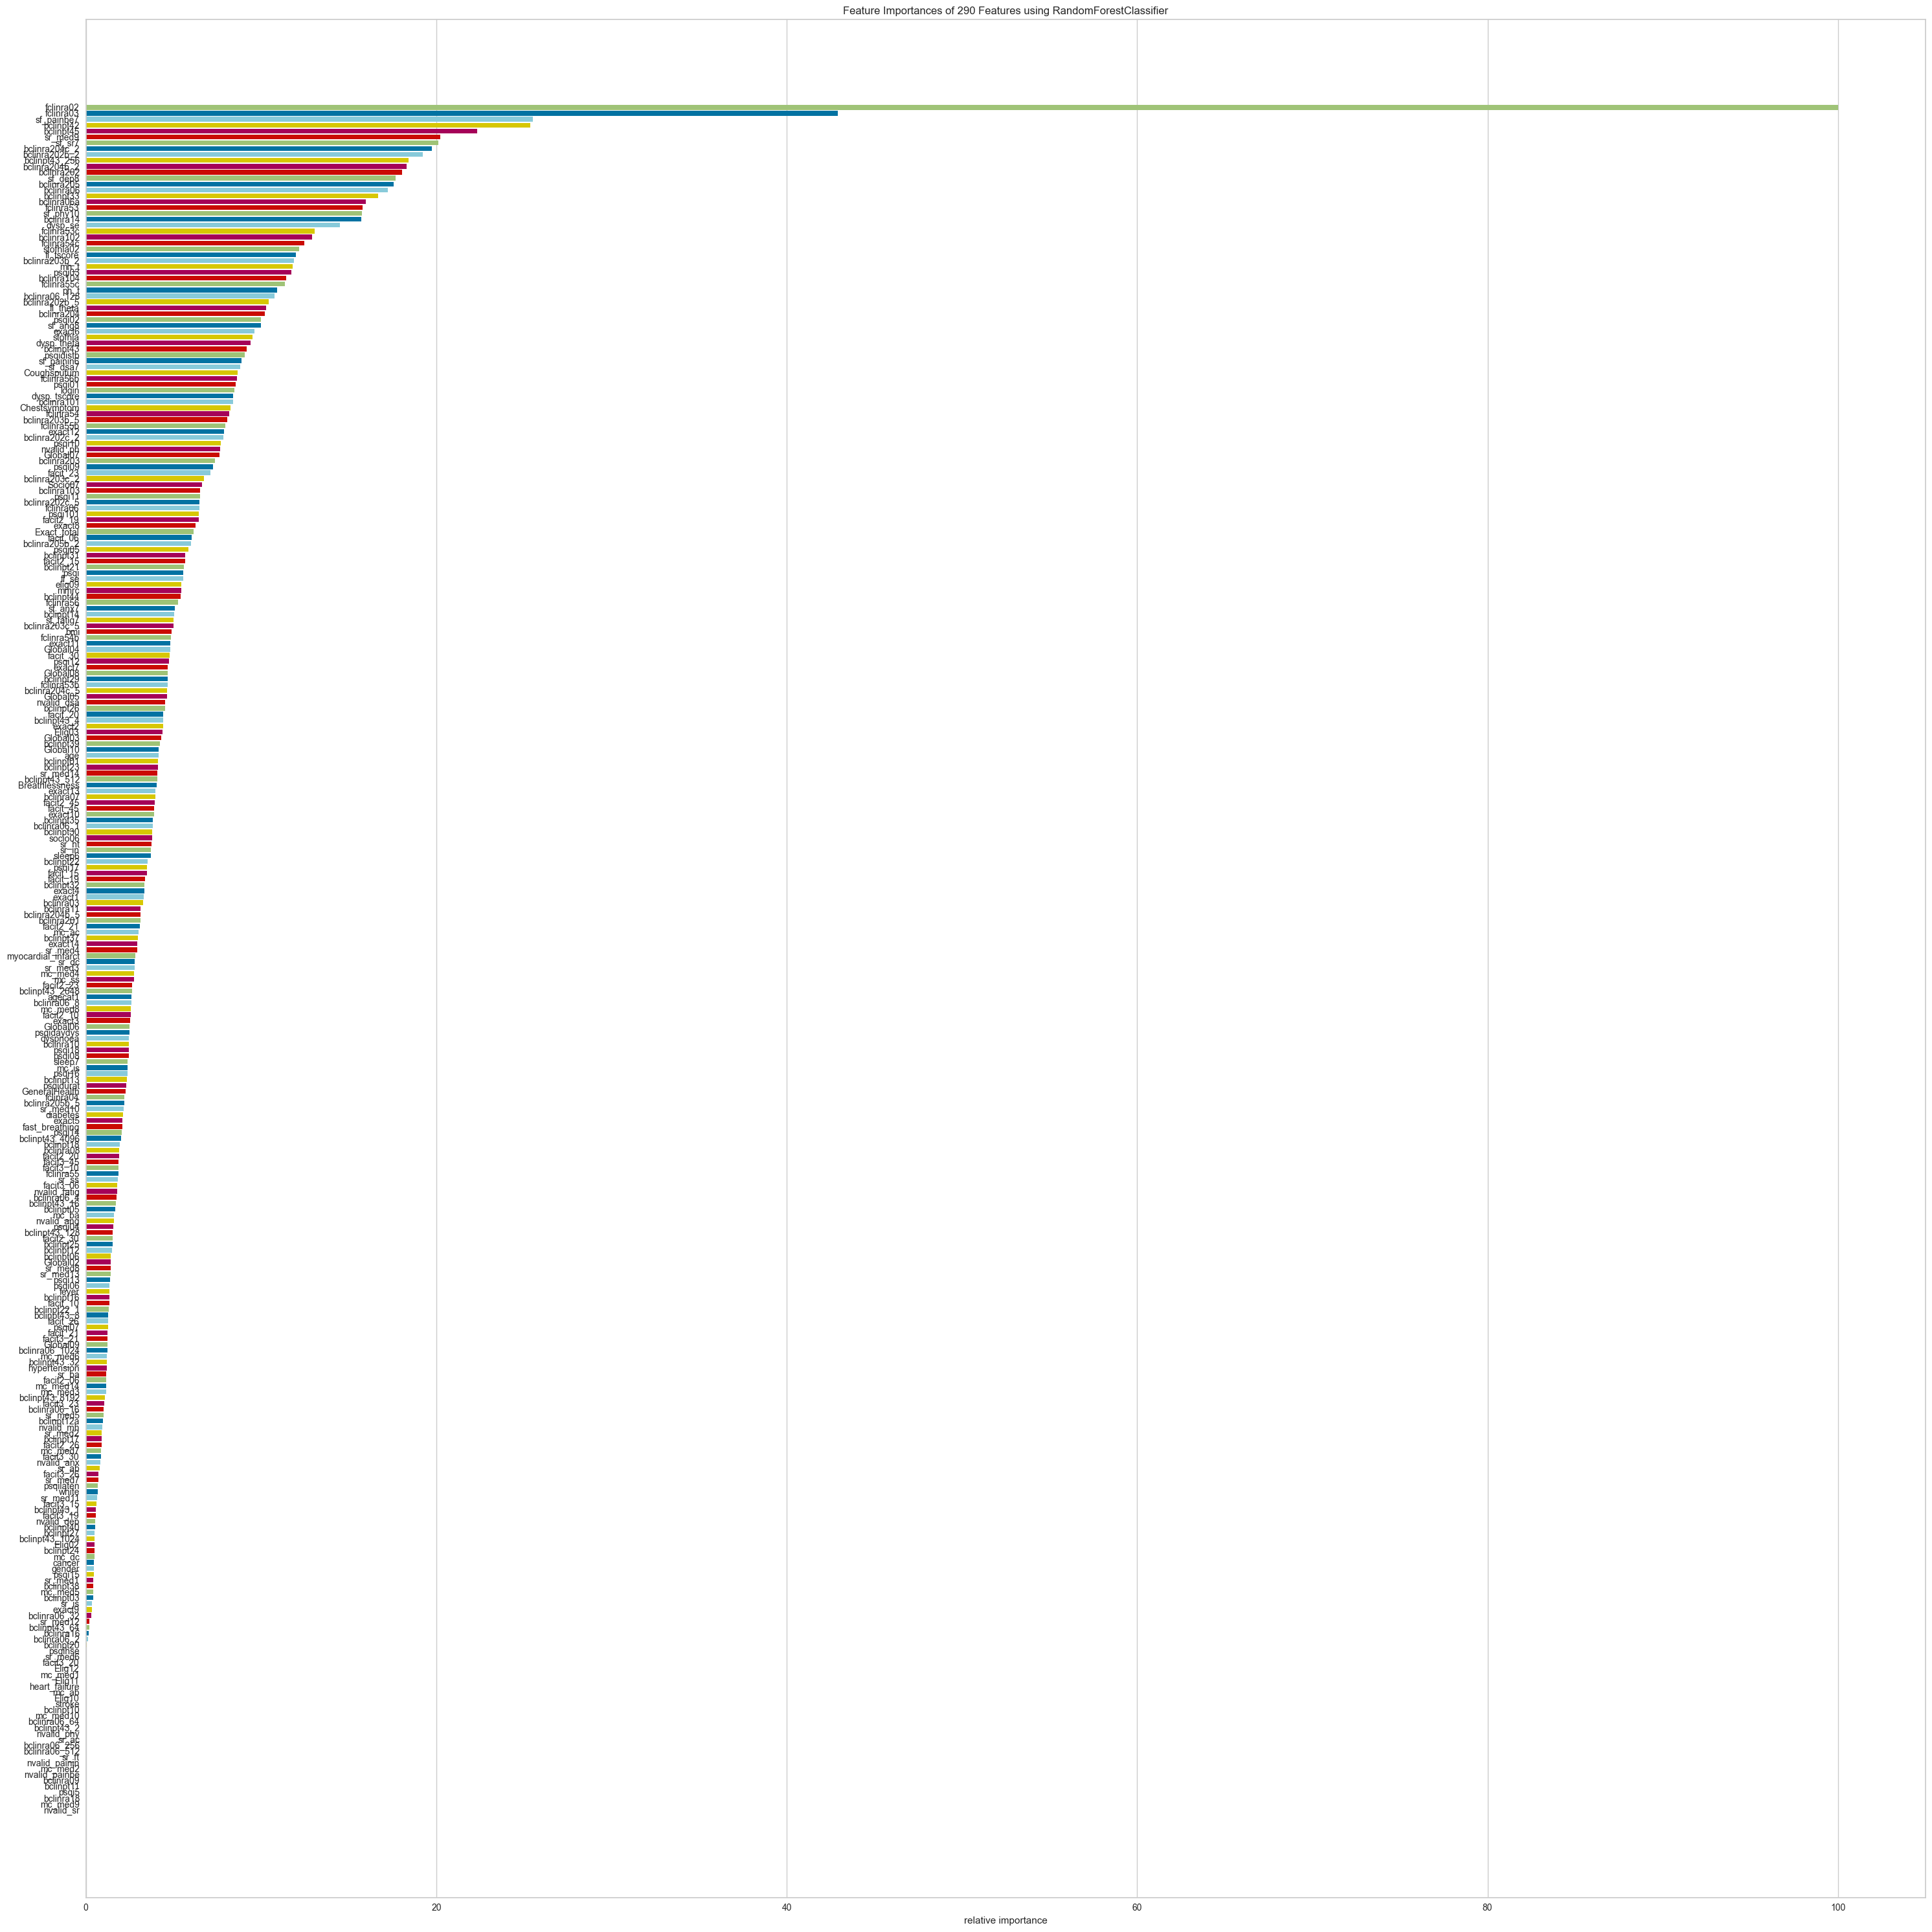

In [ ]:
# show feature importances using random forest
# print("feature importances")
X = harvard.drop(columns=['target'])
y = harvard['target']

# print(X.columns)
# print(y)

# print(X.shape)

# print(X.columns)



In [ ]:
# # take care of missing values in baseline dataset
# # print total missing values
# print(baseline_df.isnull().sum().sum())
# # drop all columns that contain more than 50% missing values
# baseline = baseline_df.dropna(thresh=baseline_df.shape[0]*0.5, how='all', axis=1)
# # drop all records where flcinra08 is missing
# baseline = baseline.dropna(subset=["fclinra08"])

# # drop variables that contain strings bclinpt44	bclinpt45 bclinra06a bclinpt41 bclinra201 psqi101
# baseline = baseline.drop(["bclinra06a"], axis=1)

# # replace all spaces with nan
# baseline = baseline.replace(r'^\s*$', np.nan, regex=True)
# # replace all values that contain "E+" with nan
# baseline = baseline.replace(r'^.*E\+.*$', np.nan, regex=True)

# # drop unnecessary columns 'bclinpt02', 'fclinra03', 'chart_bmi', 'sr_bmi', 'psqi01', 'psqi03 sr_ht_cm      bclinpt02_kg       weight_diff       height_diff
# baseline = baseline.drop(["bclinpt02", "fclinra03", "chart_bmi", "sr_bmi", "psqi01", "psqi03", "sr_ht_cm", "bclinpt02_kg", "weight_diff", "height_diff", "sgrq_tot_r"], axis=1)



# # get all numerical variables
# numerical = baseline.select_dtypes(include=['float64', 'int64'])

# # impute all categorical variables with the mode
# # for column in categorical.columns:
# #     baseline[column] = baseline[column].fillna(baseline[column].mode()[0])
# # impute all numerical variables with the median
# for column in numerical.columns:
#     baseline[column] = baseline[column].fillna(baseline[column].median())

# # find any string value. Do not rely on pandas object dtype
# for column in baseline.columns:
    


# # balance the dataset using smote
# from imblearn.over_sampling import SMOTE
# target = baseline["fclinra08"]
# # drop target variable from dataset
# baseline = baseline.drop("fclinra08", axis=1)
# # create smote object
# sm = SMOTE(random_state=42)
# # resample dataset
# baseline, target = sm.fit_resample(baseline, target)

# # create new dataframe with balanced dataset
# baseline = pd.concat([baseline, target], axis=1)

# print(baseline["fclinra08"].value_counts())

# # print missing values
# # print(baseline.isnull().sum().sum())

# # print variables with object dtype
# print(baseline.select_dtypes(include=['object']).columns)

# Classification

In [ ]:
from sklearn.svm import SVC

# target is fclinra08 (new exacerbation during study period)
target = harvard['target']

# drop target variable from dataset
classification_df = harvard.drop("target", axis=1)

# only keep age, bmi and mmrc
# classification_df = classification_df[['age', 'bmi', 'mmrc']]

# create train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(classification_df, target, test_size=0.3, random_state=42)
# # convert to numpy array
# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()
# # convert y_value to int
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

from lazypredict.Supervised import LazyClassifier

# create lazy classifier
clf = LazyClassifier()
# fit model
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

# import random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# create random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# clf = SVC(kernel='linear', random_state=42, probability=True)

# fit model
clf.fit(X_train, y_train)
# predict on test set
y_pred = clf.predict(X_test)
# print accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# # visualize classifier using yellowbricks
# from yellowbrick.classifier import ClassificationReport
# # create classification report
# visualizer = ClassificationReport(clf, classes=['no exacerbation', 'exacerbation'], support=True)
# # fit model
# visualizer.fit(X_train, y_train)
# # evaluate model on test data
# visualizer.score(X_test, y_test)
# # show visualization
# visualizer.show()

#make it binary classification problem
X = X_train[np.logical_or(y_train==0,y_train==1)]
Y = y_train[np.logical_or(y_train==0,y_train==1)]


# # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# # Solve for w3 (z)
# z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

# tmp = np.linspace(-5,5,30)
# x,y = np.meshgrid(tmp,tmp)

# fig = plt.figure()
# ax  = fig.add_subplot(111, projection='3d')
# ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
# ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
# ax.plot_surface(x, y, z(x,y))
# ax.view_init(30, 60)
# plt.show()

# harvard_feature_importances = {}
# features = list(harvard.drop(columns=['target']).columns)
# for i in range(len(features)):
#     harvard_feature_importances[features[i]] = []
# # fit a random forest classifier to the 'harvard' dataset
# for i in range(10):
#     X_train, X_test, y_train, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
#     clf.fit(X_train, y_train)
    
#     # add feature importances to dictionary
#     for feature, importance in zip(features, clf.feature_importances_):
#         if feature in harvard_feature_importances.keys():
#             harvard_feature_importances[feature].append(importance)
#         else:
#             harvard_feature_importances[feature] = [importance]
# fig, axs = plt.subplots(1, 3, figsize=(20, 20))
# for feature, importance in harvard_feature_importances.items():
#     axs[1].boxplot(importance, positions=[features.index(feature)])
# axs[1].set_xticklabels(features, rotation=90)
# axs[1].set_title('Harvard')

# print(harvard)

100%|██████████| 29/29 [00:00<00:00, 40.10it/s]


                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.89               0.89     0.89      0.89   
XGBClassifier                      0.87               0.87     0.87      0.87   
LGBMClassifier                     0.87               0.87     0.87      0.87   
ExtraTreesClassifier               0.85               0.85     0.85      0.85   
NuSVC                              0.84               0.85     0.85      0.84   
LabelSpreading                     0.84               0.85     0.85      0.84   
LabelPropagation                   0.84               0.85     0.85      0.84   
BaggingClassifier                  0.84               0.84     0.84      0.84   
SVC                                0.80               0.81     0.81      0.80   
DecisionTreeClassifier             0.80               0.80     0.80      0.80   
QuadraticDiscriminantAnalysi

In [ ]:
# perform hyperparameter tuning for random forest
from sklearn.model_selection import GridSearchCV
# create random forest classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# create parameter grid
param_grid = {
    'n_estimators': [10,30,50,100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'criterion': ['gini', 'entropy']
}

# create grid search object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
# fit grid search object to training data
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.8951690821256039


(262,)
(66,)
Accuracy (fold 0): 0.8787878787878788
(262,)
(66,)
Accuracy (fold 1): 0.8636363636363636
(262,)
(66,)
Accuracy (fold 2): 0.9090909090909091
(263,)
(65,)
Accuracy (fold 3): 0.9384615384615385
(263,)
(65,)
Accuracy (fold 4): 0.8923076923076924


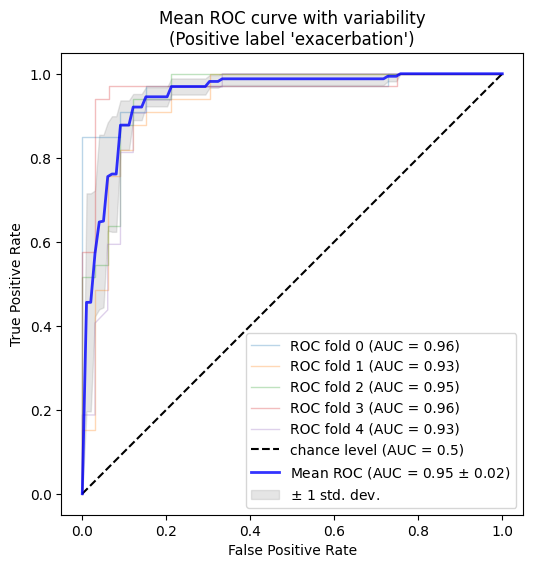

In [ ]:
# create ROC plot for random forest
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# create 100 random folds of the harvard data
from sklearn.model_selection import StratifiedKFold
X = harvard.drop(columns=['target']).to_numpy()
y = harvard['target'].to_numpy()
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
classifier = RandomForestClassifier(n_estimators=100, criterion='entropy',max_depth=10, max_features='auto', n_jobs=-1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    print(train.shape)
    print(test.shape)
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    accuracy = classifier.score(X[test], y[test])
    print(f"Accuracy (fold {fold}): {accuracy}")
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'exacerbation')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()
    

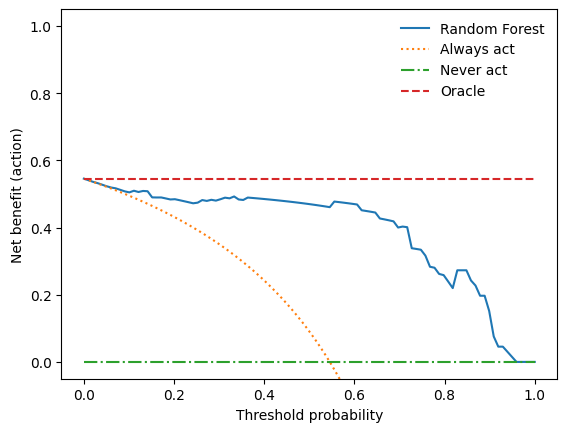

In [ ]:
# create a DCA plot for random forest
from sklearn.calibration import calibration_curve
# TODO apply the model k-fold and get the mean Net Benefit

from statkit.decision import NetBenefitDisplay
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict_proba(X_test)[:, 1]
NetBenefitDisplay.from_predictions(y_test, y_pred, name="Random Forest")

In [ ]:
# find out how many of the stable patients experienced an exacerbation within the 12 months

# find out how many of the unstable patients experienced and exacerbation within the 12 months


# find out how many patients dropped out